# PINN: Navier Stokes equation, flow around cylindar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn.functional import relu

## neural net

In [17]:
print('test')
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1=nn.Linear(3, 20)
        self.l2=nn.Linear(20, 20)
        self.l3=nn.Linear(20, 20)
        self.l4=nn.Linear(20, 20)
        self.l5=nn.Linear(20, 20)
        self.l6=nn.Linear(20, 20)
        self.l7=nn.Linear(20, 20)
        self.l8=nn.Linear(20, 20)
        self.l9=nn.Linear(20, 20)
        self.l10=nn.Linear(20, 2)
        
    def forward(self, t,x,y):
        txy = torch.cat([t,x,y],axis=1)
        out=torch.tanh(self.l1(txy)) #does not work wth only relu, tanh better than sigmoid
        out=torch.tanh(self.l2(out))
        out=torch.tanh(self.l3(out))
        out=torch.tanh(self.l4(out))
        out=torch.tanh(self.l5(out))
        out=torch.tanh(self.l6(out))
        out=torch.tanh(self.l7(out))
        out=torch.tanh(self.l8(out))
        out=torch.tanh(self.l9(out))
        out=self.l10(out)
        return out
k=1
m=1
def f(net,t,x,y):
    psi=net(t,x,y)[:,0]
    p=net(t,x,y)[:,1]
    u = torch.autograd.grad(psi.sum(), y, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), x, create_graph=True)[0]
    ux = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    uy = torch.autograd.grad(u.sum(), y, create_graph=True)[0]
    vx = torch.autograd.grad(v.sum(), x, create_graph=True)[0]
    vy = torch.autograd.grad(v.sum(), y, create_graph=True)[0]
    uxx = torch.autograd.grad(ux.sum(), x, create_graph=True)[0]
    uyy = torch.autograd.grad(uy.sum(), y, create_graph=True)[0]
    vxx = torch.autograd.grad(vx.sum(), x, create_graph=True)[0]
    vyy = torch.autograd.grad(vy.sum(), y, create_graph=True)[0]
    ut = 0#torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    vt = 0#torch.autograd.grad(v.sum(), t, create_graph=True)[0]
    px = torch.autograd.grad(p.sum(), x, create_graph=True)[0]
    py = torch.autograd.grad(p.sum(), y, create_graph=True)[0]
    f1=ut+(u*ux+v*uy)*1000+px-0.001*(uxx+uyy) #1260 1500
    f2=vt+(u*vx+v*vy)*1000+py-0.001*(vxx+vyy)
    mse1=nn.MSELoss()
    pt0 = Variable(torch.zeros_like(u), requires_grad=False).to(device)
    loss = mse1(f1,pt0)+mse1(f2, pt0)
    return loss

def u_err_y(net,u_bd,v_bd,y_bd):
    t_bc=np.zeros(1)
    x_bc=np.random.rand(1000)*20.0
    y_bc=np.ones(1)*y_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    #pt_u_bc = Variable(torch.from_numpy(u_bcm).float(), requires_grad=True).to(device)
    #pt_v_bc = Variable(torch.from_numpy(v_bcm).float(), requires_grad=True).to(device)
    psi=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
    u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
    mse1=nn.MSELoss()
    u0 = Variable(torch.ones_like(u)*u_bd, requires_grad=False).to(device)
    v0 = Variable(torch.ones_like(v)*v_bd, requires_grad=False).to(device)
    loss=mse1(u,u0)+mse1(v,v0)
    return loss

def u_err_x(net,u_bd,v_bd,x_bd):
    t_bc=np.zeros(1)
    y_bc=np.random.rand(1000)*1.0
    x_bc=np.ones(1)*x_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    #pt_u_bc = Variable(torch.from_numpy(u_bcm).float(), requires_grad=True).to(device)
    #pt_v_bc = Variable(torch.from_numpy(v_bcm).float(), requires_grad=True).to(device)
    psi=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
    u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
    mse1=nn.MSELoss()
    u0 = Variable(torch.ones_like(u)*u_bd, requires_grad=False).to(device)
    v0 = Variable(torch.ones_like(v)*v_bd, requires_grad=False).to(device)
    loss=mse1(u,u0)+mse1(v,v0)
    return loss

def u_err_circle(net,xm,ym,r):
    t_bc=np.zeros(1)
    phi=np.random.rand(1000)*2*np.pi
    t_bcm,phi_bcm=np.meshgrid(t_bc,phi)
    y_bcm=r*np.sin(phi_bcm)+ym
    x_bcm=r*np.cos(phi_bcm)+xm
    
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    #pt_u_bc = Variable(torch.from_numpy(u_bcm).float(), requires_grad=True).to(device)
    #pt_v_bc = Variable(torch.from_numpy(v_bcm).float(), requires_grad=True).to(device)
    psi=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
    u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
    v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
    mse1=nn.MSELoss()
    u0 = Variable(torch.zeros_like(u), requires_grad=False).to(device)
    v0 = Variable(torch.zeros_like(v), requires_grad=False).to(device)
    loss=mse1(u,u0)+mse1(v,v0)
    return loss

def u_err_p(net,p_bd,x_bd):
    t_bc=np.zeros(1)
    y_bc=np.random.rand(1000)*1.0
    x_bc=np.ones(1)*x_bd
    t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
    t_bcm=np.reshape(t_bcm,(1000,1))
    x_bcm=np.reshape(x_bcm,(1000,1))
    y_bcm=np.reshape(y_bcm,(1000,1))
    pt_t_bc = Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
    pt_x_bc = Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
    pt_y_bc = Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
    p=net(pt_t_bc,pt_x_bc,pt_y_bc)[:,1]
    mse1=nn.MSELoss()
    p0 = Variable(torch.ones_like(p)*p_bd, requires_grad=False).to(device)
    loss=mse1(p,p0)
    return loss


test
Using cpu device


## train net

In [29]:

model = NeuralNetwork().to(device)
#optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
optimizer=torch.optim.Adam(model.parameters())
for i in range(10000):
    optimizer.zero_grad()
    loss1=u_err_circle(model,10.0,0.5,0.1)+u_err_y(model,0.001,0.0,0.0)+u_err_y(model,0.001,0.0,1.0)+u_err_x(model,0.001,0.0,20.0) +u_err_x(model,0.001,0.0,0.0)
    
    #pred_bc=model(pt_t_bc)
    #loss1=u(model,t0,u0)
    #pt01 = Variable(torch.from_numpy(np.zeros((2,1))).float(), requires_grad=False).to(device)
    
    t=np.zeros((1000,1))
    x=np.random.rand(1000,1)*20.0
    y=np.random.rand(1000,1)*1.0
    pt_t= Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
    pt_x= Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
    pt_y= Variable(torch.from_numpy(y).float(), requires_grad=True).to(device)
    loss2=f(model,pt_t, pt_x,pt_y)

    loss = loss2+100*loss1
    #loss = mse2(loss2,pt02)+mse1(pred_bc, pt01)

    # Backpropagation
    loss.backward()
    optimizer.step()
    print(i)
    print(loss1)
    print(loss2)

0
tensor(2.6419e-06, grad_fn=<AddBackward0>)
tensor(2.6456e-07, grad_fn=<AddBackward0>)
1
tensor(2.0143e-06, grad_fn=<AddBackward0>)
tensor(2.5143e-07, grad_fn=<AddBackward0>)
2
tensor(2.2485e-06, grad_fn=<AddBackward0>)
tensor(2.1656e-07, grad_fn=<AddBackward0>)
3
tensor(1.9078e-06, grad_fn=<AddBackward0>)
tensor(2.1549e-07, grad_fn=<AddBackward0>)
4
tensor(1.6901e-06, grad_fn=<AddBackward0>)
tensor(2.2677e-07, grad_fn=<AddBackward0>)
5
tensor(1.6936e-06, grad_fn=<AddBackward0>)
tensor(2.1622e-07, grad_fn=<AddBackward0>)
6
tensor(1.7115e-06, grad_fn=<AddBackward0>)
tensor(2.3041e-07, grad_fn=<AddBackward0>)
7
tensor(1.6623e-06, grad_fn=<AddBackward0>)
tensor(2.2722e-07, grad_fn=<AddBackward0>)
8
tensor(1.5388e-06, grad_fn=<AddBackward0>)
tensor(2.3345e-07, grad_fn=<AddBackward0>)
9
tensor(1.4139e-06, grad_fn=<AddBackward0>)
tensor(2.1359e-07, grad_fn=<AddBackward0>)
10
tensor(1.3762e-06, grad_fn=<AddBackward0>)
tensor(1.9734e-07, grad_fn=<AddBackward0>)
11
tensor(1.3763e-06, grad_fn=<

94
tensor(4.2215e-07, grad_fn=<AddBackward0>)
tensor(9.3993e-09, grad_fn=<AddBackward0>)
95
tensor(4.3170e-07, grad_fn=<AddBackward0>)
tensor(1.0241e-08, grad_fn=<AddBackward0>)
96
tensor(4.3522e-07, grad_fn=<AddBackward0>)
tensor(1.1628e-08, grad_fn=<AddBackward0>)
97
tensor(4.3720e-07, grad_fn=<AddBackward0>)
tensor(9.3701e-09, grad_fn=<AddBackward0>)
98
tensor(4.3887e-07, grad_fn=<AddBackward0>)
tensor(1.3049e-08, grad_fn=<AddBackward0>)
99
tensor(4.1726e-07, grad_fn=<AddBackward0>)
tensor(1.1139e-08, grad_fn=<AddBackward0>)
100
tensor(4.2148e-07, grad_fn=<AddBackward0>)
tensor(1.0758e-08, grad_fn=<AddBackward0>)
101
tensor(4.3183e-07, grad_fn=<AddBackward0>)
tensor(1.2841e-08, grad_fn=<AddBackward0>)
102
tensor(4.1721e-07, grad_fn=<AddBackward0>)
tensor(9.7908e-09, grad_fn=<AddBackward0>)
103
tensor(4.1159e-07, grad_fn=<AddBackward0>)
tensor(1.1471e-08, grad_fn=<AddBackward0>)
104
tensor(4.2692e-07, grad_fn=<AddBackward0>)
tensor(1.2134e-08, grad_fn=<AddBackward0>)
105
tensor(4.231

187
tensor(3.7085e-07, grad_fn=<AddBackward0>)
tensor(9.5495e-09, grad_fn=<AddBackward0>)
188
tensor(3.5772e-07, grad_fn=<AddBackward0>)
tensor(1.1717e-08, grad_fn=<AddBackward0>)
189
tensor(3.6196e-07, grad_fn=<AddBackward0>)
tensor(1.0345e-08, grad_fn=<AddBackward0>)
190
tensor(3.6913e-07, grad_fn=<AddBackward0>)
tensor(1.0233e-08, grad_fn=<AddBackward0>)
191
tensor(3.6680e-07, grad_fn=<AddBackward0>)
tensor(1.2572e-08, grad_fn=<AddBackward0>)
192
tensor(3.6963e-07, grad_fn=<AddBackward0>)
tensor(1.0170e-08, grad_fn=<AddBackward0>)
193
tensor(3.6445e-07, grad_fn=<AddBackward0>)
tensor(1.1762e-08, grad_fn=<AddBackward0>)
194
tensor(3.5907e-07, grad_fn=<AddBackward0>)
tensor(9.9915e-09, grad_fn=<AddBackward0>)
195
tensor(3.6063e-07, grad_fn=<AddBackward0>)
tensor(1.0386e-08, grad_fn=<AddBackward0>)
196
tensor(3.7342e-07, grad_fn=<AddBackward0>)
tensor(1.0504e-08, grad_fn=<AddBackward0>)
197
tensor(3.6542e-07, grad_fn=<AddBackward0>)
tensor(1.1372e-08, grad_fn=<AddBackward0>)
198
tensor

280
tensor(3.3116e-07, grad_fn=<AddBackward0>)
tensor(8.9898e-09, grad_fn=<AddBackward0>)
281
tensor(3.2690e-07, grad_fn=<AddBackward0>)
tensor(9.5130e-09, grad_fn=<AddBackward0>)
282
tensor(3.2027e-07, grad_fn=<AddBackward0>)
tensor(8.6795e-09, grad_fn=<AddBackward0>)
283
tensor(3.2669e-07, grad_fn=<AddBackward0>)
tensor(9.9544e-09, grad_fn=<AddBackward0>)
284
tensor(3.3508e-07, grad_fn=<AddBackward0>)
tensor(8.3662e-09, grad_fn=<AddBackward0>)
285
tensor(3.5050e-07, grad_fn=<AddBackward0>)
tensor(1.0137e-08, grad_fn=<AddBackward0>)
286
tensor(3.9301e-07, grad_fn=<AddBackward0>)
tensor(8.0153e-09, grad_fn=<AddBackward0>)
287
tensor(5.0932e-07, grad_fn=<AddBackward0>)
tensor(1.6494e-08, grad_fn=<AddBackward0>)
288
tensor(6.1773e-07, grad_fn=<AddBackward0>)
tensor(7.9803e-09, grad_fn=<AddBackward0>)
289
tensor(5.0824e-07, grad_fn=<AddBackward0>)
tensor(1.2656e-08, grad_fn=<AddBackward0>)
290
tensor(3.2993e-07, grad_fn=<AddBackward0>)
tensor(7.1495e-09, grad_fn=<AddBackward0>)
291
tensor

373
tensor(3.0100e-07, grad_fn=<AddBackward0>)
tensor(8.7310e-09, grad_fn=<AddBackward0>)
374
tensor(3.2340e-07, grad_fn=<AddBackward0>)
tensor(5.9281e-09, grad_fn=<AddBackward0>)
375
tensor(3.5479e-07, grad_fn=<AddBackward0>)
tensor(1.1115e-08, grad_fn=<AddBackward0>)
376
tensor(4.0598e-07, grad_fn=<AddBackward0>)
tensor(5.2568e-09, grad_fn=<AddBackward0>)
377
tensor(4.5909e-07, grad_fn=<AddBackward0>)
tensor(1.2922e-08, grad_fn=<AddBackward0>)
378
tensor(4.6015e-07, grad_fn=<AddBackward0>)
tensor(4.9532e-09, grad_fn=<AddBackward0>)
379
tensor(3.6274e-07, grad_fn=<AddBackward0>)
tensor(1.0567e-08, grad_fn=<AddBackward0>)
380
tensor(2.9810e-07, grad_fn=<AddBackward0>)
tensor(6.7802e-09, grad_fn=<AddBackward0>)
381
tensor(3.3295e-07, grad_fn=<AddBackward0>)
tensor(5.1103e-09, grad_fn=<AddBackward0>)
382
tensor(3.5658e-07, grad_fn=<AddBackward0>)
tensor(9.0027e-09, grad_fn=<AddBackward0>)
383
tensor(3.1151e-07, grad_fn=<AddBackward0>)
tensor(5.4838e-09, grad_fn=<AddBackward0>)
384
tensor

465
tensor(2.6697e-07, grad_fn=<AddBackward0>)
tensor(7.2752e-09, grad_fn=<AddBackward0>)
466
tensor(2.6418e-07, grad_fn=<AddBackward0>)
tensor(7.5458e-09, grad_fn=<AddBackward0>)
467
tensor(2.6663e-07, grad_fn=<AddBackward0>)
tensor(7.3313e-09, grad_fn=<AddBackward0>)
468
tensor(2.5965e-07, grad_fn=<AddBackward0>)
tensor(7.7842e-09, grad_fn=<AddBackward0>)
469
tensor(2.6346e-07, grad_fn=<AddBackward0>)
tensor(7.2554e-09, grad_fn=<AddBackward0>)
470
tensor(2.4764e-07, grad_fn=<AddBackward0>)
tensor(7.1763e-09, grad_fn=<AddBackward0>)
471
tensor(2.5441e-07, grad_fn=<AddBackward0>)
tensor(7.8351e-09, grad_fn=<AddBackward0>)
472
tensor(2.5448e-07, grad_fn=<AddBackward0>)
tensor(7.7181e-09, grad_fn=<AddBackward0>)
473
tensor(2.5593e-07, grad_fn=<AddBackward0>)
tensor(6.9244e-09, grad_fn=<AddBackward0>)
474
tensor(2.5202e-07, grad_fn=<AddBackward0>)
tensor(8.2296e-09, grad_fn=<AddBackward0>)
475
tensor(2.5725e-07, grad_fn=<AddBackward0>)
tensor(7.6696e-09, grad_fn=<AddBackward0>)
476
tensor

557
tensor(2.3147e-07, grad_fn=<AddBackward0>)
tensor(7.3317e-09, grad_fn=<AddBackward0>)
558
tensor(2.3092e-07, grad_fn=<AddBackward0>)
tensor(6.7712e-09, grad_fn=<AddBackward0>)
559
tensor(2.3380e-07, grad_fn=<AddBackward0>)
tensor(5.8921e-09, grad_fn=<AddBackward0>)
560
tensor(2.2702e-07, grad_fn=<AddBackward0>)
tensor(7.4570e-09, grad_fn=<AddBackward0>)
561
tensor(2.2441e-07, grad_fn=<AddBackward0>)
tensor(6.7092e-09, grad_fn=<AddBackward0>)
562
tensor(2.3014e-07, grad_fn=<AddBackward0>)
tensor(6.7779e-09, grad_fn=<AddBackward0>)
563
tensor(2.3410e-07, grad_fn=<AddBackward0>)
tensor(7.4930e-09, grad_fn=<AddBackward0>)
564
tensor(2.2141e-07, grad_fn=<AddBackward0>)
tensor(7.6497e-09, grad_fn=<AddBackward0>)
565
tensor(2.2733e-07, grad_fn=<AddBackward0>)
tensor(7.1190e-09, grad_fn=<AddBackward0>)
566
tensor(2.2693e-07, grad_fn=<AddBackward0>)
tensor(7.8241e-09, grad_fn=<AddBackward0>)
567
tensor(2.1048e-07, grad_fn=<AddBackward0>)
tensor(7.2158e-09, grad_fn=<AddBackward0>)
568
tensor

649
tensor(5.5752e-07, grad_fn=<AddBackward0>)
tensor(9.3926e-09, grad_fn=<AddBackward0>)
650
tensor(4.5290e-07, grad_fn=<AddBackward0>)
tensor(8.9064e-09, grad_fn=<AddBackward0>)
651
tensor(3.0753e-07, grad_fn=<AddBackward0>)
tensor(4.9026e-09, grad_fn=<AddBackward0>)
652
tensor(4.3464e-07, grad_fn=<AddBackward0>)
tensor(4.7188e-09, grad_fn=<AddBackward0>)
653
tensor(4.7405e-07, grad_fn=<AddBackward0>)
tensor(4.4776e-09, grad_fn=<AddBackward0>)
654
tensor(3.4518e-07, grad_fn=<AddBackward0>)
tensor(5.4885e-09, grad_fn=<AddBackward0>)
655
tensor(3.3073e-07, grad_fn=<AddBackward0>)
tensor(6.1925e-09, grad_fn=<AddBackward0>)
656
tensor(4.1210e-07, grad_fn=<AddBackward0>)
tensor(8.7382e-09, grad_fn=<AddBackward0>)
657
tensor(3.9202e-07, grad_fn=<AddBackward0>)
tensor(8.1157e-09, grad_fn=<AddBackward0>)
658
tensor(3.1916e-07, grad_fn=<AddBackward0>)
tensor(6.1474e-09, grad_fn=<AddBackward0>)
659
tensor(3.3071e-07, grad_fn=<AddBackward0>)
tensor(5.0746e-09, grad_fn=<AddBackward0>)
660
tensor

742
tensor(1.9759e-07, grad_fn=<AddBackward0>)
tensor(8.7365e-09, grad_fn=<AddBackward0>)
743
tensor(1.9506e-07, grad_fn=<AddBackward0>)
tensor(9.2158e-09, grad_fn=<AddBackward0>)
744
tensor(1.9327e-07, grad_fn=<AddBackward0>)
tensor(7.7802e-09, grad_fn=<AddBackward0>)
745
tensor(1.9677e-07, grad_fn=<AddBackward0>)
tensor(8.0012e-09, grad_fn=<AddBackward0>)
746
tensor(1.9143e-07, grad_fn=<AddBackward0>)
tensor(8.5201e-09, grad_fn=<AddBackward0>)
747
tensor(1.9111e-07, grad_fn=<AddBackward0>)
tensor(8.9068e-09, grad_fn=<AddBackward0>)
748
tensor(1.9109e-07, grad_fn=<AddBackward0>)
tensor(8.8272e-09, grad_fn=<AddBackward0>)
749
tensor(1.9140e-07, grad_fn=<AddBackward0>)
tensor(9.1040e-09, grad_fn=<AddBackward0>)
750
tensor(1.9073e-07, grad_fn=<AddBackward0>)
tensor(8.9420e-09, grad_fn=<AddBackward0>)
751
tensor(1.8533e-07, grad_fn=<AddBackward0>)
tensor(9.0837e-09, grad_fn=<AddBackward0>)
752
tensor(1.8320e-07, grad_fn=<AddBackward0>)
tensor(8.8083e-09, grad_fn=<AddBackward0>)
753
tensor

835
tensor(1.9677e-07, grad_fn=<AddBackward0>)
tensor(8.5752e-09, grad_fn=<AddBackward0>)
836
tensor(1.8960e-07, grad_fn=<AddBackward0>)
tensor(6.9681e-09, grad_fn=<AddBackward0>)
837
tensor(1.8946e-07, grad_fn=<AddBackward0>)
tensor(8.5344e-09, grad_fn=<AddBackward0>)
838
tensor(1.8661e-07, grad_fn=<AddBackward0>)
tensor(7.8449e-09, grad_fn=<AddBackward0>)
839
tensor(1.8411e-07, grad_fn=<AddBackward0>)
tensor(8.1535e-09, grad_fn=<AddBackward0>)
840
tensor(1.8768e-07, grad_fn=<AddBackward0>)
tensor(7.8655e-09, grad_fn=<AddBackward0>)
841
tensor(1.8541e-07, grad_fn=<AddBackward0>)
tensor(9.6217e-09, grad_fn=<AddBackward0>)
842
tensor(1.8323e-07, grad_fn=<AddBackward0>)
tensor(9.5007e-09, grad_fn=<AddBackward0>)
843
tensor(1.7444e-07, grad_fn=<AddBackward0>)
tensor(1.0030e-08, grad_fn=<AddBackward0>)
844
tensor(1.8032e-07, grad_fn=<AddBackward0>)
tensor(8.0985e-09, grad_fn=<AddBackward0>)
845
tensor(1.7533e-07, grad_fn=<AddBackward0>)
tensor(9.6749e-09, grad_fn=<AddBackward0>)
846
tensor

928
tensor(2.4973e-07, grad_fn=<AddBackward0>)
tensor(5.4426e-09, grad_fn=<AddBackward0>)
929
tensor(2.5479e-07, grad_fn=<AddBackward0>)
tensor(4.8432e-09, grad_fn=<AddBackward0>)
930
tensor(2.5250e-07, grad_fn=<AddBackward0>)
tensor(4.5882e-09, grad_fn=<AddBackward0>)
931
tensor(2.4607e-07, grad_fn=<AddBackward0>)
tensor(4.5292e-09, grad_fn=<AddBackward0>)
932
tensor(2.5468e-07, grad_fn=<AddBackward0>)
tensor(4.7808e-09, grad_fn=<AddBackward0>)
933
tensor(2.4024e-07, grad_fn=<AddBackward0>)
tensor(5.6893e-09, grad_fn=<AddBackward0>)
934
tensor(2.4704e-07, grad_fn=<AddBackward0>)
tensor(6.0731e-09, grad_fn=<AddBackward0>)
935
tensor(2.4129e-07, grad_fn=<AddBackward0>)
tensor(5.4885e-09, grad_fn=<AddBackward0>)
936
tensor(2.2847e-07, grad_fn=<AddBackward0>)
tensor(5.8132e-09, grad_fn=<AddBackward0>)
937
tensor(2.3311e-07, grad_fn=<AddBackward0>)
tensor(4.5086e-09, grad_fn=<AddBackward0>)
938
tensor(2.3358e-07, grad_fn=<AddBackward0>)
tensor(4.6886e-09, grad_fn=<AddBackward0>)
939
tensor

1020
tensor(1.1362e-07, grad_fn=<AddBackward0>)
tensor(1.3347e-08, grad_fn=<AddBackward0>)
1021
tensor(1.1229e-07, grad_fn=<AddBackward0>)
tensor(1.2985e-08, grad_fn=<AddBackward0>)
1022
tensor(1.1217e-07, grad_fn=<AddBackward0>)
tensor(1.3816e-08, grad_fn=<AddBackward0>)
1023
tensor(1.1285e-07, grad_fn=<AddBackward0>)
tensor(1.4355e-08, grad_fn=<AddBackward0>)
1024
tensor(1.0913e-07, grad_fn=<AddBackward0>)
tensor(1.3764e-08, grad_fn=<AddBackward0>)
1025
tensor(1.1452e-07, grad_fn=<AddBackward0>)
tensor(1.3779e-08, grad_fn=<AddBackward0>)
1026
tensor(1.1324e-07, grad_fn=<AddBackward0>)
tensor(1.4721e-08, grad_fn=<AddBackward0>)
1027
tensor(1.0947e-07, grad_fn=<AddBackward0>)
tensor(1.2692e-08, grad_fn=<AddBackward0>)
1028
tensor(1.0896e-07, grad_fn=<AddBackward0>)
tensor(1.5464e-08, grad_fn=<AddBackward0>)
1029
tensor(1.0814e-07, grad_fn=<AddBackward0>)
tensor(1.6111e-08, grad_fn=<AddBackward0>)
1030
tensor(1.1116e-07, grad_fn=<AddBackward0>)
tensor(1.3825e-08, grad_fn=<AddBackward0>)

1111
tensor(1.2745e-07, grad_fn=<AddBackward0>)
tensor(1.3291e-08, grad_fn=<AddBackward0>)
1112
tensor(1.3028e-07, grad_fn=<AddBackward0>)
tensor(1.1533e-08, grad_fn=<AddBackward0>)
1113
tensor(1.2511e-07, grad_fn=<AddBackward0>)
tensor(1.1112e-08, grad_fn=<AddBackward0>)
1114
tensor(1.2606e-07, grad_fn=<AddBackward0>)
tensor(1.4356e-08, grad_fn=<AddBackward0>)
1115
tensor(1.2492e-07, grad_fn=<AddBackward0>)
tensor(1.3911e-08, grad_fn=<AddBackward0>)
1116
tensor(1.2095e-07, grad_fn=<AddBackward0>)
tensor(1.2664e-08, grad_fn=<AddBackward0>)
1117
tensor(1.2329e-07, grad_fn=<AddBackward0>)
tensor(1.1523e-08, grad_fn=<AddBackward0>)
1118
tensor(1.1903e-07, grad_fn=<AddBackward0>)
tensor(1.2563e-08, grad_fn=<AddBackward0>)
1119
tensor(1.2072e-07, grad_fn=<AddBackward0>)
tensor(1.3552e-08, grad_fn=<AddBackward0>)
1120
tensor(1.1693e-07, grad_fn=<AddBackward0>)
tensor(1.2838e-08, grad_fn=<AddBackward0>)
1121
tensor(1.1198e-07, grad_fn=<AddBackward0>)
tensor(1.1438e-08, grad_fn=<AddBackward0>)

1202
tensor(8.7907e-08, grad_fn=<AddBackward0>)
tensor(1.9165e-08, grad_fn=<AddBackward0>)
1203
tensor(7.9455e-08, grad_fn=<AddBackward0>)
tensor(1.9395e-08, grad_fn=<AddBackward0>)
1204
tensor(8.6726e-08, grad_fn=<AddBackward0>)
tensor(2.0090e-08, grad_fn=<AddBackward0>)
1205
tensor(9.0339e-08, grad_fn=<AddBackward0>)
tensor(1.9165e-08, grad_fn=<AddBackward0>)
1206
tensor(7.8857e-08, grad_fn=<AddBackward0>)
tensor(1.8181e-08, grad_fn=<AddBackward0>)
1207
tensor(7.8526e-08, grad_fn=<AddBackward0>)
tensor(1.7739e-08, grad_fn=<AddBackward0>)
1208
tensor(8.6148e-08, grad_fn=<AddBackward0>)
tensor(2.0145e-08, grad_fn=<AddBackward0>)
1209
tensor(8.4627e-08, grad_fn=<AddBackward0>)
tensor(2.1629e-08, grad_fn=<AddBackward0>)
1210
tensor(7.7529e-08, grad_fn=<AddBackward0>)
tensor(1.8262e-08, grad_fn=<AddBackward0>)
1211
tensor(7.7304e-08, grad_fn=<AddBackward0>)
tensor(1.8933e-08, grad_fn=<AddBackward0>)
1212
tensor(7.9839e-08, grad_fn=<AddBackward0>)
tensor(2.3189e-08, grad_fn=<AddBackward0>)

1293
tensor(9.8726e-08, grad_fn=<AddBackward0>)
tensor(1.2290e-08, grad_fn=<AddBackward0>)
1294
tensor(1.0305e-07, grad_fn=<AddBackward0>)
tensor(1.3124e-08, grad_fn=<AddBackward0>)
1295
tensor(9.8291e-08, grad_fn=<AddBackward0>)
tensor(1.3115e-08, grad_fn=<AddBackward0>)
1296
tensor(9.5297e-08, grad_fn=<AddBackward0>)
tensor(1.2537e-08, grad_fn=<AddBackward0>)
1297
tensor(8.9694e-08, grad_fn=<AddBackward0>)
tensor(1.0987e-08, grad_fn=<AddBackward0>)
1298
tensor(9.4039e-08, grad_fn=<AddBackward0>)
tensor(1.3830e-08, grad_fn=<AddBackward0>)
1299
tensor(9.3241e-08, grad_fn=<AddBackward0>)
tensor(1.4722e-08, grad_fn=<AddBackward0>)
1300
tensor(8.8162e-08, grad_fn=<AddBackward0>)
tensor(1.3061e-08, grad_fn=<AddBackward0>)
1301
tensor(8.8589e-08, grad_fn=<AddBackward0>)
tensor(1.4370e-08, grad_fn=<AddBackward0>)
1302
tensor(8.8325e-08, grad_fn=<AddBackward0>)
tensor(1.3276e-08, grad_fn=<AddBackward0>)
1303
tensor(8.8595e-08, grad_fn=<AddBackward0>)
tensor(1.4973e-08, grad_fn=<AddBackward0>)

1385
tensor(8.3278e-08, grad_fn=<AddBackward0>)
tensor(1.1311e-08, grad_fn=<AddBackward0>)
1386
tensor(8.9126e-08, grad_fn=<AddBackward0>)
tensor(1.5410e-08, grad_fn=<AddBackward0>)
1387
tensor(8.4833e-08, grad_fn=<AddBackward0>)
tensor(1.3988e-08, grad_fn=<AddBackward0>)
1388
tensor(8.0957e-08, grad_fn=<AddBackward0>)
tensor(1.4915e-08, grad_fn=<AddBackward0>)
1389
tensor(8.6344e-08, grad_fn=<AddBackward0>)
tensor(1.5690e-08, grad_fn=<AddBackward0>)
1390
tensor(8.1332e-08, grad_fn=<AddBackward0>)
tensor(1.6397e-08, grad_fn=<AddBackward0>)
1391
tensor(8.1717e-08, grad_fn=<AddBackward0>)
tensor(1.3037e-08, grad_fn=<AddBackward0>)
1392
tensor(8.0844e-08, grad_fn=<AddBackward0>)
tensor(1.4596e-08, grad_fn=<AddBackward0>)
1393
tensor(8.2216e-08, grad_fn=<AddBackward0>)
tensor(1.5511e-08, grad_fn=<AddBackward0>)
1394
tensor(7.8370e-08, grad_fn=<AddBackward0>)
tensor(1.4591e-08, grad_fn=<AddBackward0>)
1395
tensor(7.8714e-08, grad_fn=<AddBackward0>)
tensor(1.4286e-08, grad_fn=<AddBackward0>)

1476
tensor(6.9866e-08, grad_fn=<AddBackward0>)
tensor(2.1326e-08, grad_fn=<AddBackward0>)
1477
tensor(7.4601e-08, grad_fn=<AddBackward0>)
tensor(1.6908e-08, grad_fn=<AddBackward0>)
1478
tensor(5.7520e-08, grad_fn=<AddBackward0>)
tensor(1.8779e-08, grad_fn=<AddBackward0>)
1479
tensor(5.6240e-08, grad_fn=<AddBackward0>)
tensor(1.8221e-08, grad_fn=<AddBackward0>)
1480
tensor(6.9825e-08, grad_fn=<AddBackward0>)
tensor(1.8054e-08, grad_fn=<AddBackward0>)
1481
tensor(6.6837e-08, grad_fn=<AddBackward0>)
tensor(2.3339e-08, grad_fn=<AddBackward0>)
1482
tensor(5.7275e-08, grad_fn=<AddBackward0>)
tensor(2.0256e-08, grad_fn=<AddBackward0>)
1483
tensor(5.7392e-08, grad_fn=<AddBackward0>)
tensor(2.0222e-08, grad_fn=<AddBackward0>)
1484
tensor(6.4994e-08, grad_fn=<AddBackward0>)
tensor(2.2404e-08, grad_fn=<AddBackward0>)
1485
tensor(6.5179e-08, grad_fn=<AddBackward0>)
tensor(1.6984e-08, grad_fn=<AddBackward0>)
1486
tensor(5.6026e-08, grad_fn=<AddBackward0>)
tensor(1.9481e-08, grad_fn=<AddBackward0>)

1567
tensor(4.9175e-08, grad_fn=<AddBackward0>)
tensor(2.0263e-08, grad_fn=<AddBackward0>)
1568
tensor(4.9615e-08, grad_fn=<AddBackward0>)
tensor(2.0001e-08, grad_fn=<AddBackward0>)
1569
tensor(5.0527e-08, grad_fn=<AddBackward0>)
tensor(2.0707e-08, grad_fn=<AddBackward0>)
1570
tensor(5.3063e-08, grad_fn=<AddBackward0>)
tensor(2.3175e-08, grad_fn=<AddBackward0>)
1571
tensor(6.1375e-08, grad_fn=<AddBackward0>)
tensor(1.6624e-08, grad_fn=<AddBackward0>)
1572
tensor(7.5913e-08, grad_fn=<AddBackward0>)
tensor(2.5605e-08, grad_fn=<AddBackward0>)
1573
tensor(1.0505e-07, grad_fn=<AddBackward0>)
tensor(1.9174e-08, grad_fn=<AddBackward0>)
1574
tensor(1.4931e-07, grad_fn=<AddBackward0>)
tensor(2.9272e-08, grad_fn=<AddBackward0>)
1575
tensor(2.2850e-07, grad_fn=<AddBackward0>)
tensor(1.4707e-08, grad_fn=<AddBackward0>)
1576
tensor(3.4982e-07, grad_fn=<AddBackward0>)
tensor(4.1205e-08, grad_fn=<AddBackward0>)
1577
tensor(5.3899e-07, grad_fn=<AddBackward0>)
tensor(1.2631e-08, grad_fn=<AddBackward0>)

1659
tensor(4.3878e-08, grad_fn=<AddBackward0>)
tensor(1.8956e-08, grad_fn=<AddBackward0>)
1660
tensor(4.2967e-08, grad_fn=<AddBackward0>)
tensor(1.8277e-08, grad_fn=<AddBackward0>)
1661
tensor(4.2644e-08, grad_fn=<AddBackward0>)
tensor(1.7797e-08, grad_fn=<AddBackward0>)
1662
tensor(4.3092e-08, grad_fn=<AddBackward0>)
tensor(1.9272e-08, grad_fn=<AddBackward0>)
1663
tensor(4.2829e-08, grad_fn=<AddBackward0>)
tensor(2.1754e-08, grad_fn=<AddBackward0>)
1664
tensor(4.2722e-08, grad_fn=<AddBackward0>)
tensor(1.8945e-08, grad_fn=<AddBackward0>)
1665
tensor(4.5425e-08, grad_fn=<AddBackward0>)
tensor(2.0459e-08, grad_fn=<AddBackward0>)
1666
tensor(5.0180e-08, grad_fn=<AddBackward0>)
tensor(1.7604e-08, grad_fn=<AddBackward0>)
1667
tensor(6.2276e-08, grad_fn=<AddBackward0>)
tensor(2.3186e-08, grad_fn=<AddBackward0>)
1668
tensor(8.2781e-08, grad_fn=<AddBackward0>)
tensor(1.8447e-08, grad_fn=<AddBackward0>)
1669
tensor(1.1011e-07, grad_fn=<AddBackward0>)
tensor(2.5881e-08, grad_fn=<AddBackward0>)

1751
tensor(4.0572e-08, grad_fn=<AddBackward0>)
tensor(1.6528e-08, grad_fn=<AddBackward0>)
1752
tensor(4.0874e-08, grad_fn=<AddBackward0>)
tensor(1.6914e-08, grad_fn=<AddBackward0>)
1753
tensor(4.1617e-08, grad_fn=<AddBackward0>)
tensor(1.9815e-08, grad_fn=<AddBackward0>)
1754
tensor(4.2768e-08, grad_fn=<AddBackward0>)
tensor(2.0647e-08, grad_fn=<AddBackward0>)
1755
tensor(4.3205e-08, grad_fn=<AddBackward0>)
tensor(1.7448e-08, grad_fn=<AddBackward0>)
1756
tensor(4.5738e-08, grad_fn=<AddBackward0>)
tensor(1.8908e-08, grad_fn=<AddBackward0>)
1757
tensor(4.9242e-08, grad_fn=<AddBackward0>)
tensor(1.7837e-08, grad_fn=<AddBackward0>)
1758
tensor(5.2694e-08, grad_fn=<AddBackward0>)
tensor(2.1403e-08, grad_fn=<AddBackward0>)
1759
tensor(5.4221e-08, grad_fn=<AddBackward0>)
tensor(1.8649e-08, grad_fn=<AddBackward0>)
1760
tensor(5.5019e-08, grad_fn=<AddBackward0>)
tensor(2.0809e-08, grad_fn=<AddBackward0>)
1761
tensor(5.8170e-08, grad_fn=<AddBackward0>)
tensor(1.9429e-08, grad_fn=<AddBackward0>)

1843
tensor(3.6621e-08, grad_fn=<AddBackward0>)
tensor(1.2799e-08, grad_fn=<AddBackward0>)
1844
tensor(3.6115e-08, grad_fn=<AddBackward0>)
tensor(1.7449e-08, grad_fn=<AddBackward0>)
1845
tensor(3.6568e-08, grad_fn=<AddBackward0>)
tensor(1.5141e-08, grad_fn=<AddBackward0>)
1846
tensor(3.5661e-08, grad_fn=<AddBackward0>)
tensor(1.7125e-08, grad_fn=<AddBackward0>)
1847
tensor(3.6196e-08, grad_fn=<AddBackward0>)
tensor(1.6922e-08, grad_fn=<AddBackward0>)
1848
tensor(3.8370e-08, grad_fn=<AddBackward0>)
tensor(1.3896e-08, grad_fn=<AddBackward0>)
1849
tensor(3.9602e-08, grad_fn=<AddBackward0>)
tensor(1.7972e-08, grad_fn=<AddBackward0>)
1850
tensor(4.2548e-08, grad_fn=<AddBackward0>)
tensor(1.5637e-08, grad_fn=<AddBackward0>)
1851
tensor(4.4781e-08, grad_fn=<AddBackward0>)
tensor(1.7997e-08, grad_fn=<AddBackward0>)
1852
tensor(4.9072e-08, grad_fn=<AddBackward0>)
tensor(1.4019e-08, grad_fn=<AddBackward0>)
1853
tensor(5.4693e-08, grad_fn=<AddBackward0>)
tensor(1.8026e-08, grad_fn=<AddBackward0>)

1934
tensor(5.4649e-08, grad_fn=<AddBackward0>)
tensor(1.3591e-08, grad_fn=<AddBackward0>)
1935
tensor(4.1373e-08, grad_fn=<AddBackward0>)
tensor(1.2253e-08, grad_fn=<AddBackward0>)
1936
tensor(4.6388e-08, grad_fn=<AddBackward0>)
tensor(1.2041e-08, grad_fn=<AddBackward0>)
1937
tensor(5.1546e-08, grad_fn=<AddBackward0>)
tensor(1.3080e-08, grad_fn=<AddBackward0>)
1938
tensor(4.1891e-08, grad_fn=<AddBackward0>)
tensor(1.1713e-08, grad_fn=<AddBackward0>)
1939
tensor(3.9874e-08, grad_fn=<AddBackward0>)
tensor(1.1304e-08, grad_fn=<AddBackward0>)
1940
tensor(4.6636e-08, grad_fn=<AddBackward0>)
tensor(1.4481e-08, grad_fn=<AddBackward0>)
1941
tensor(4.2060e-08, grad_fn=<AddBackward0>)
tensor(1.1358e-08, grad_fn=<AddBackward0>)
1942
tensor(3.7739e-08, grad_fn=<AddBackward0>)
tensor(1.1036e-08, grad_fn=<AddBackward0>)
1943
tensor(4.3107e-08, grad_fn=<AddBackward0>)
tensor(1.2520e-08, grad_fn=<AddBackward0>)
1944
tensor(4.3150e-08, grad_fn=<AddBackward0>)
tensor(1.1310e-08, grad_fn=<AddBackward0>)

2026
tensor(5.4187e-08, grad_fn=<AddBackward0>)
tensor(9.3851e-09, grad_fn=<AddBackward0>)
2027
tensor(5.1428e-08, grad_fn=<AddBackward0>)
tensor(9.2666e-09, grad_fn=<AddBackward0>)
2028
tensor(5.1716e-08, grad_fn=<AddBackward0>)
tensor(9.5825e-09, grad_fn=<AddBackward0>)
2029
tensor(5.1469e-08, grad_fn=<AddBackward0>)
tensor(9.8864e-09, grad_fn=<AddBackward0>)
2030
tensor(4.6239e-08, grad_fn=<AddBackward0>)
tensor(9.8445e-09, grad_fn=<AddBackward0>)
2031
tensor(5.4091e-08, grad_fn=<AddBackward0>)
tensor(1.1280e-08, grad_fn=<AddBackward0>)
2032
tensor(4.3232e-08, grad_fn=<AddBackward0>)
tensor(9.6416e-09, grad_fn=<AddBackward0>)
2033
tensor(4.7151e-08, grad_fn=<AddBackward0>)
tensor(9.8037e-09, grad_fn=<AddBackward0>)
2034
tensor(4.5537e-08, grad_fn=<AddBackward0>)
tensor(1.0772e-08, grad_fn=<AddBackward0>)
2035
tensor(4.2898e-08, grad_fn=<AddBackward0>)
tensor(1.0645e-08, grad_fn=<AddBackward0>)
2036
tensor(4.5383e-08, grad_fn=<AddBackward0>)
tensor(9.8809e-09, grad_fn=<AddBackward0>)

2118
tensor(3.4940e-08, grad_fn=<AddBackward0>)
tensor(1.4497e-08, grad_fn=<AddBackward0>)
2119
tensor(3.0734e-08, grad_fn=<AddBackward0>)
tensor(1.0872e-08, grad_fn=<AddBackward0>)
2120
tensor(2.9415e-08, grad_fn=<AddBackward0>)
tensor(1.2909e-08, grad_fn=<AddBackward0>)
2121
tensor(2.9114e-08, grad_fn=<AddBackward0>)
tensor(1.2484e-08, grad_fn=<AddBackward0>)
2122
tensor(3.0432e-08, grad_fn=<AddBackward0>)
tensor(1.2562e-08, grad_fn=<AddBackward0>)
2123
tensor(3.3043e-08, grad_fn=<AddBackward0>)
tensor(1.3574e-08, grad_fn=<AddBackward0>)
2124
tensor(3.4748e-08, grad_fn=<AddBackward0>)
tensor(1.1735e-08, grad_fn=<AddBackward0>)
2125
tensor(3.7011e-08, grad_fn=<AddBackward0>)
tensor(1.2199e-08, grad_fn=<AddBackward0>)
2126
tensor(4.0427e-08, grad_fn=<AddBackward0>)
tensor(1.1444e-08, grad_fn=<AddBackward0>)
2127
tensor(4.2622e-08, grad_fn=<AddBackward0>)
tensor(1.4463e-08, grad_fn=<AddBackward0>)
2128
tensor(4.2046e-08, grad_fn=<AddBackward0>)
tensor(1.1453e-08, grad_fn=<AddBackward0>)

2210
tensor(2.7272e-08, grad_fn=<AddBackward0>)
tensor(1.0912e-08, grad_fn=<AddBackward0>)
2211
tensor(2.7780e-08, grad_fn=<AddBackward0>)
tensor(1.0028e-08, grad_fn=<AddBackward0>)
2212
tensor(2.6815e-08, grad_fn=<AddBackward0>)
tensor(1.2259e-08, grad_fn=<AddBackward0>)
2213
tensor(2.6633e-08, grad_fn=<AddBackward0>)
tensor(1.2864e-08, grad_fn=<AddBackward0>)
2214
tensor(2.6124e-08, grad_fn=<AddBackward0>)
tensor(1.0403e-08, grad_fn=<AddBackward0>)
2215
tensor(2.6864e-08, grad_fn=<AddBackward0>)
tensor(1.2442e-08, grad_fn=<AddBackward0>)
2216
tensor(2.6805e-08, grad_fn=<AddBackward0>)
tensor(1.2490e-08, grad_fn=<AddBackward0>)
2217
tensor(2.5102e-08, grad_fn=<AddBackward0>)
tensor(1.2953e-08, grad_fn=<AddBackward0>)
2218
tensor(2.5517e-08, grad_fn=<AddBackward0>)
tensor(1.1426e-08, grad_fn=<AddBackward0>)
2219
tensor(2.6106e-08, grad_fn=<AddBackward0>)
tensor(1.2064e-08, grad_fn=<AddBackward0>)
2220
tensor(2.5522e-08, grad_fn=<AddBackward0>)
tensor(1.2083e-08, grad_fn=<AddBackward0>)

2302
tensor(2.6158e-08, grad_fn=<AddBackward0>)
tensor(1.1313e-08, grad_fn=<AddBackward0>)
2303
tensor(2.5894e-08, grad_fn=<AddBackward0>)
tensor(1.1373e-08, grad_fn=<AddBackward0>)
2304
tensor(2.6785e-08, grad_fn=<AddBackward0>)
tensor(1.1747e-08, grad_fn=<AddBackward0>)
2305
tensor(2.6421e-08, grad_fn=<AddBackward0>)
tensor(1.1821e-08, grad_fn=<AddBackward0>)
2306
tensor(2.6663e-08, grad_fn=<AddBackward0>)
tensor(1.1805e-08, grad_fn=<AddBackward0>)
2307
tensor(2.6424e-08, grad_fn=<AddBackward0>)
tensor(1.1123e-08, grad_fn=<AddBackward0>)
2308
tensor(2.7091e-08, grad_fn=<AddBackward0>)
tensor(1.1899e-08, grad_fn=<AddBackward0>)
2309
tensor(2.7419e-08, grad_fn=<AddBackward0>)
tensor(1.0777e-08, grad_fn=<AddBackward0>)
2310
tensor(2.6201e-08, grad_fn=<AddBackward0>)
tensor(1.2433e-08, grad_fn=<AddBackward0>)
2311
tensor(2.5498e-08, grad_fn=<AddBackward0>)
tensor(1.1389e-08, grad_fn=<AddBackward0>)
2312
tensor(2.4821e-08, grad_fn=<AddBackward0>)
tensor(1.1281e-08, grad_fn=<AddBackward0>)

2394
tensor(2.8232e-08, grad_fn=<AddBackward0>)
tensor(1.2477e-08, grad_fn=<AddBackward0>)
2395
tensor(2.7832e-08, grad_fn=<AddBackward0>)
tensor(1.0586e-08, grad_fn=<AddBackward0>)
2396
tensor(2.6753e-08, grad_fn=<AddBackward0>)
tensor(1.1616e-08, grad_fn=<AddBackward0>)
2397
tensor(2.5409e-08, grad_fn=<AddBackward0>)
tensor(1.0212e-08, grad_fn=<AddBackward0>)
2398
tensor(2.3246e-08, grad_fn=<AddBackward0>)
tensor(1.0856e-08, grad_fn=<AddBackward0>)
2399
tensor(2.2241e-08, grad_fn=<AddBackward0>)
tensor(1.2314e-08, grad_fn=<AddBackward0>)
2400
tensor(2.4544e-08, grad_fn=<AddBackward0>)
tensor(9.5862e-09, grad_fn=<AddBackward0>)
2401
tensor(2.6384e-08, grad_fn=<AddBackward0>)
tensor(1.1325e-08, grad_fn=<AddBackward0>)
2402
tensor(2.9314e-08, grad_fn=<AddBackward0>)
tensor(9.5098e-09, grad_fn=<AddBackward0>)
2403
tensor(3.1423e-08, grad_fn=<AddBackward0>)
tensor(1.2624e-08, grad_fn=<AddBackward0>)
2404
tensor(3.2945e-08, grad_fn=<AddBackward0>)
tensor(9.5388e-09, grad_fn=<AddBackward0>)

2486
tensor(4.7428e-08, grad_fn=<AddBackward0>)
tensor(8.3666e-09, grad_fn=<AddBackward0>)
2487
tensor(5.6628e-08, grad_fn=<AddBackward0>)
tensor(7.7389e-09, grad_fn=<AddBackward0>)
2488
tensor(4.4111e-08, grad_fn=<AddBackward0>)
tensor(1.0866e-08, grad_fn=<AddBackward0>)
2489
tensor(4.9558e-08, grad_fn=<AddBackward0>)
tensor(9.9461e-09, grad_fn=<AddBackward0>)
2490
tensor(4.2953e-08, grad_fn=<AddBackward0>)
tensor(7.2237e-09, grad_fn=<AddBackward0>)
2491
tensor(4.2610e-08, grad_fn=<AddBackward0>)
tensor(7.7137e-09, grad_fn=<AddBackward0>)
2492
tensor(4.3104e-08, grad_fn=<AddBackward0>)
tensor(9.0593e-09, grad_fn=<AddBackward0>)
2493
tensor(3.7023e-08, grad_fn=<AddBackward0>)
tensor(8.2569e-09, grad_fn=<AddBackward0>)
2494
tensor(4.4390e-08, grad_fn=<AddBackward0>)
tensor(7.2898e-09, grad_fn=<AddBackward0>)
2495
tensor(3.5591e-08, grad_fn=<AddBackward0>)
tensor(9.0411e-09, grad_fn=<AddBackward0>)
2496
tensor(3.7054e-08, grad_fn=<AddBackward0>)
tensor(8.3709e-09, grad_fn=<AddBackward0>)

2578
tensor(6.3006e-08, grad_fn=<AddBackward0>)
tensor(9.7347e-09, grad_fn=<AddBackward0>)
2579
tensor(4.2878e-08, grad_fn=<AddBackward0>)
tensor(7.3219e-09, grad_fn=<AddBackward0>)
2580
tensor(6.0495e-08, grad_fn=<AddBackward0>)
tensor(6.6821e-09, grad_fn=<AddBackward0>)
2581
tensor(4.1750e-08, grad_fn=<AddBackward0>)
tensor(8.4426e-09, grad_fn=<AddBackward0>)
2582
tensor(5.3677e-08, grad_fn=<AddBackward0>)
tensor(9.3928e-09, grad_fn=<AddBackward0>)
2583
tensor(4.4823e-08, grad_fn=<AddBackward0>)
tensor(7.8965e-09, grad_fn=<AddBackward0>)
2584
tensor(4.4344e-08, grad_fn=<AddBackward0>)
tensor(8.2198e-09, grad_fn=<AddBackward0>)
2585
tensor(5.0020e-08, grad_fn=<AddBackward0>)
tensor(8.5423e-09, grad_fn=<AddBackward0>)
2586
tensor(3.7466e-08, grad_fn=<AddBackward0>)
tensor(6.8436e-09, grad_fn=<AddBackward0>)
2587
tensor(4.7076e-08, grad_fn=<AddBackward0>)
tensor(6.8304e-09, grad_fn=<AddBackward0>)
2588
tensor(4.1516e-08, grad_fn=<AddBackward0>)
tensor(9.2334e-09, grad_fn=<AddBackward0>)

2670
tensor(3.1638e-08, grad_fn=<AddBackward0>)
tensor(9.8552e-09, grad_fn=<AddBackward0>)
2671
tensor(3.1456e-08, grad_fn=<AddBackward0>)
tensor(1.0738e-08, grad_fn=<AddBackward0>)
2672
tensor(3.0547e-08, grad_fn=<AddBackward0>)
tensor(8.7682e-09, grad_fn=<AddBackward0>)
2673
tensor(2.9015e-08, grad_fn=<AddBackward0>)
tensor(1.0983e-08, grad_fn=<AddBackward0>)
2674
tensor(2.7523e-08, grad_fn=<AddBackward0>)
tensor(7.6965e-09, grad_fn=<AddBackward0>)
2675
tensor(2.6302e-08, grad_fn=<AddBackward0>)
tensor(9.6978e-09, grad_fn=<AddBackward0>)
2676
tensor(2.6806e-08, grad_fn=<AddBackward0>)
tensor(7.9300e-09, grad_fn=<AddBackward0>)
2677
tensor(2.7746e-08, grad_fn=<AddBackward0>)
tensor(1.1436e-08, grad_fn=<AddBackward0>)
2678
tensor(2.8835e-08, grad_fn=<AddBackward0>)
tensor(7.8599e-09, grad_fn=<AddBackward0>)
2679
tensor(2.8625e-08, grad_fn=<AddBackward0>)
tensor(1.0546e-08, grad_fn=<AddBackward0>)
2680
tensor(2.8488e-08, grad_fn=<AddBackward0>)
tensor(9.3511e-09, grad_fn=<AddBackward0>)

2762
tensor(2.4591e-08, grad_fn=<AddBackward0>)
tensor(9.4131e-09, grad_fn=<AddBackward0>)
2763
tensor(2.1764e-08, grad_fn=<AddBackward0>)
tensor(8.7999e-09, grad_fn=<AddBackward0>)
2764
tensor(2.0531e-08, grad_fn=<AddBackward0>)
tensor(8.6014e-09, grad_fn=<AddBackward0>)
2765
tensor(2.1385e-08, grad_fn=<AddBackward0>)
tensor(1.0280e-08, grad_fn=<AddBackward0>)
2766
tensor(2.3403e-08, grad_fn=<AddBackward0>)
tensor(8.2797e-09, grad_fn=<AddBackward0>)
2767
tensor(2.5730e-08, grad_fn=<AddBackward0>)
tensor(1.0022e-08, grad_fn=<AddBackward0>)
2768
tensor(2.8021e-08, grad_fn=<AddBackward0>)
tensor(9.8365e-09, grad_fn=<AddBackward0>)
2769
tensor(3.0253e-08, grad_fn=<AddBackward0>)
tensor(7.8768e-09, grad_fn=<AddBackward0>)
2770
tensor(3.2488e-08, grad_fn=<AddBackward0>)
tensor(1.1123e-08, grad_fn=<AddBackward0>)
2771
tensor(3.2898e-08, grad_fn=<AddBackward0>)
tensor(7.4467e-09, grad_fn=<AddBackward0>)
2772
tensor(3.2261e-08, grad_fn=<AddBackward0>)
tensor(9.3076e-09, grad_fn=<AddBackward0>)

2853
tensor(3.7968e-08, grad_fn=<AddBackward0>)
tensor(9.2899e-09, grad_fn=<AddBackward0>)
2854
tensor(2.6452e-08, grad_fn=<AddBackward0>)
tensor(6.8470e-09, grad_fn=<AddBackward0>)
2855
tensor(2.4680e-08, grad_fn=<AddBackward0>)
tensor(7.3151e-09, grad_fn=<AddBackward0>)
2856
tensor(3.3729e-08, grad_fn=<AddBackward0>)
tensor(9.2268e-09, grad_fn=<AddBackward0>)
2857
tensor(3.1096e-08, grad_fn=<AddBackward0>)
tensor(6.3631e-09, grad_fn=<AddBackward0>)
2858
tensor(2.1528e-08, grad_fn=<AddBackward0>)
tensor(7.8282e-09, grad_fn=<AddBackward0>)
2859
tensor(2.5217e-08, grad_fn=<AddBackward0>)
tensor(8.5190e-09, grad_fn=<AddBackward0>)
2860
tensor(2.9766e-08, grad_fn=<AddBackward0>)
tensor(6.2811e-09, grad_fn=<AddBackward0>)
2861
tensor(2.5053e-08, grad_fn=<AddBackward0>)
tensor(8.5584e-09, grad_fn=<AddBackward0>)
2862
tensor(2.0893e-08, grad_fn=<AddBackward0>)
tensor(7.9825e-09, grad_fn=<AddBackward0>)
2863
tensor(2.4009e-08, grad_fn=<AddBackward0>)
tensor(7.7083e-09, grad_fn=<AddBackward0>)

2945
tensor(1.9340e-08, grad_fn=<AddBackward0>)
tensor(9.3179e-09, grad_fn=<AddBackward0>)
2946
tensor(2.0629e-08, grad_fn=<AddBackward0>)
tensor(8.0266e-09, grad_fn=<AddBackward0>)
2947
tensor(2.1395e-08, grad_fn=<AddBackward0>)
tensor(8.4388e-09, grad_fn=<AddBackward0>)
2948
tensor(2.2664e-08, grad_fn=<AddBackward0>)
tensor(7.7264e-09, grad_fn=<AddBackward0>)
2949
tensor(2.4600e-08, grad_fn=<AddBackward0>)
tensor(9.2160e-09, grad_fn=<AddBackward0>)
2950
tensor(2.5940e-08, grad_fn=<AddBackward0>)
tensor(8.2222e-09, grad_fn=<AddBackward0>)
2951
tensor(2.8860e-08, grad_fn=<AddBackward0>)
tensor(9.3217e-09, grad_fn=<AddBackward0>)
2952
tensor(3.3977e-08, grad_fn=<AddBackward0>)
tensor(7.3103e-09, grad_fn=<AddBackward0>)
2953
tensor(4.0910e-08, grad_fn=<AddBackward0>)
tensor(9.7071e-09, grad_fn=<AddBackward0>)
2954
tensor(5.1248e-08, grad_fn=<AddBackward0>)
tensor(7.2816e-09, grad_fn=<AddBackward0>)
2955
tensor(6.3364e-08, grad_fn=<AddBackward0>)
tensor(1.0114e-08, grad_fn=<AddBackward0>)

3037
tensor(5.4098e-08, grad_fn=<AddBackward0>)
tensor(6.2796e-09, grad_fn=<AddBackward0>)
3038
tensor(8.3342e-08, grad_fn=<AddBackward0>)
tensor(1.2151e-08, grad_fn=<AddBackward0>)
3039
tensor(1.3720e-07, grad_fn=<AddBackward0>)
tensor(5.8699e-09, grad_fn=<AddBackward0>)
3040
tensor(2.0545e-07, grad_fn=<AddBackward0>)
tensor(1.3733e-08, grad_fn=<AddBackward0>)
3041
tensor(2.8981e-07, grad_fn=<AddBackward0>)
tensor(5.9897e-09, grad_fn=<AddBackward0>)
3042
tensor(3.0256e-07, grad_fn=<AddBackward0>)
tensor(1.3362e-08, grad_fn=<AddBackward0>)
3043
tensor(2.1908e-07, grad_fn=<AddBackward0>)
tensor(5.8881e-09, grad_fn=<AddBackward0>)
3044
tensor(6.0995e-08, grad_fn=<AddBackward0>)
tensor(9.2733e-09, grad_fn=<AddBackward0>)
3045
tensor(3.3611e-08, grad_fn=<AddBackward0>)
tensor(9.8532e-09, grad_fn=<AddBackward0>)
3046
tensor(1.1383e-07, grad_fn=<AddBackward0>)
tensor(5.2375e-09, grad_fn=<AddBackward0>)
3047
tensor(9.1331e-08, grad_fn=<AddBackward0>)
tensor(9.9524e-09, grad_fn=<AddBackward0>)

3128
tensor(3.2669e-08, grad_fn=<AddBackward0>)
tensor(7.0544e-09, grad_fn=<AddBackward0>)
3129
tensor(3.2432e-08, grad_fn=<AddBackward0>)
tensor(9.7475e-09, grad_fn=<AddBackward0>)
3130
tensor(3.0475e-08, grad_fn=<AddBackward0>)
tensor(7.9677e-09, grad_fn=<AddBackward0>)
3131
tensor(2.8069e-08, grad_fn=<AddBackward0>)
tensor(8.2304e-09, grad_fn=<AddBackward0>)
3132
tensor(2.5363e-08, grad_fn=<AddBackward0>)
tensor(7.8762e-09, grad_fn=<AddBackward0>)
3133
tensor(2.3339e-08, grad_fn=<AddBackward0>)
tensor(7.7694e-09, grad_fn=<AddBackward0>)
3134
tensor(2.1398e-08, grad_fn=<AddBackward0>)
tensor(9.6322e-09, grad_fn=<AddBackward0>)
3135
tensor(2.0153e-08, grad_fn=<AddBackward0>)
tensor(7.2436e-09, grad_fn=<AddBackward0>)
3136
tensor(2.1089e-08, grad_fn=<AddBackward0>)
tensor(9.4365e-09, grad_fn=<AddBackward0>)
3137
tensor(2.1414e-08, grad_fn=<AddBackward0>)
tensor(7.1395e-09, grad_fn=<AddBackward0>)
3138
tensor(2.0741e-08, grad_fn=<AddBackward0>)
tensor(8.0305e-09, grad_fn=<AddBackward0>)

3219
tensor(2.7083e-08, grad_fn=<AddBackward0>)
tensor(7.8774e-09, grad_fn=<AddBackward0>)
3220
tensor(3.4803e-08, grad_fn=<AddBackward0>)
tensor(9.2048e-09, grad_fn=<AddBackward0>)
3221
tensor(4.6653e-08, grad_fn=<AddBackward0>)
tensor(9.2521e-09, grad_fn=<AddBackward0>)
3222
tensor(6.7997e-08, grad_fn=<AddBackward0>)
tensor(9.3775e-09, grad_fn=<AddBackward0>)
3223
tensor(1.1092e-07, grad_fn=<AddBackward0>)
tensor(9.4976e-09, grad_fn=<AddBackward0>)
3224
tensor(1.8449e-07, grad_fn=<AddBackward0>)
tensor(1.2508e-08, grad_fn=<AddBackward0>)
3225
tensor(3.0447e-07, grad_fn=<AddBackward0>)
tensor(8.4468e-09, grad_fn=<AddBackward0>)
3226
tensor(3.7167e-07, grad_fn=<AddBackward0>)
tensor(1.3732e-08, grad_fn=<AddBackward0>)
3227
tensor(3.5145e-07, grad_fn=<AddBackward0>)
tensor(5.2080e-09, grad_fn=<AddBackward0>)
3228
tensor(1.6647e-07, grad_fn=<AddBackward0>)
tensor(1.1800e-08, grad_fn=<AddBackward0>)
3229
tensor(4.1263e-08, grad_fn=<AddBackward0>)
tensor(7.2783e-09, grad_fn=<AddBackward0>)

3310
tensor(1.5588e-08, grad_fn=<AddBackward0>)
tensor(7.2261e-09, grad_fn=<AddBackward0>)
3311
tensor(1.4951e-08, grad_fn=<AddBackward0>)
tensor(6.9704e-09, grad_fn=<AddBackward0>)
3312
tensor(1.4851e-08, grad_fn=<AddBackward0>)
tensor(7.6232e-09, grad_fn=<AddBackward0>)
3313
tensor(1.4642e-08, grad_fn=<AddBackward0>)
tensor(7.9177e-09, grad_fn=<AddBackward0>)
3314
tensor(1.4719e-08, grad_fn=<AddBackward0>)
tensor(7.7427e-09, grad_fn=<AddBackward0>)
3315
tensor(1.4651e-08, grad_fn=<AddBackward0>)
tensor(7.0316e-09, grad_fn=<AddBackward0>)
3316
tensor(1.4312e-08, grad_fn=<AddBackward0>)
tensor(8.0402e-09, grad_fn=<AddBackward0>)
3317
tensor(1.4449e-08, grad_fn=<AddBackward0>)
tensor(7.6325e-09, grad_fn=<AddBackward0>)
3318
tensor(1.4470e-08, grad_fn=<AddBackward0>)
tensor(7.5880e-09, grad_fn=<AddBackward0>)
3319
tensor(1.4492e-08, grad_fn=<AddBackward0>)
tensor(7.2348e-09, grad_fn=<AddBackward0>)
3320
tensor(1.5335e-08, grad_fn=<AddBackward0>)
tensor(7.7800e-09, grad_fn=<AddBackward0>)

3401
tensor(1.5155e-08, grad_fn=<AddBackward0>)
tensor(7.2451e-09, grad_fn=<AddBackward0>)
3402
tensor(1.6697e-08, grad_fn=<AddBackward0>)
tensor(8.8805e-09, grad_fn=<AddBackward0>)
3403
tensor(1.9925e-08, grad_fn=<AddBackward0>)
tensor(8.1231e-09, grad_fn=<AddBackward0>)
3404
tensor(2.5142e-08, grad_fn=<AddBackward0>)
tensor(8.4061e-09, grad_fn=<AddBackward0>)
3405
tensor(3.3667e-08, grad_fn=<AddBackward0>)
tensor(6.8646e-09, grad_fn=<AddBackward0>)
3406
tensor(4.9096e-08, grad_fn=<AddBackward0>)
tensor(8.9799e-09, grad_fn=<AddBackward0>)
3407
tensor(8.2937e-08, grad_fn=<AddBackward0>)
tensor(6.4148e-09, grad_fn=<AddBackward0>)
3408
tensor(1.4932e-07, grad_fn=<AddBackward0>)
tensor(1.2548e-08, grad_fn=<AddBackward0>)
3409
tensor(2.7362e-07, grad_fn=<AddBackward0>)
tensor(5.7666e-09, grad_fn=<AddBackward0>)
3410
tensor(4.1931e-07, grad_fn=<AddBackward0>)
tensor(1.4907e-08, grad_fn=<AddBackward0>)
3411
tensor(5.2966e-07, grad_fn=<AddBackward0>)
tensor(4.3163e-09, grad_fn=<AddBackward0>)

3492
tensor(1.7833e-08, grad_fn=<AddBackward0>)
tensor(6.9837e-09, grad_fn=<AddBackward0>)
3493
tensor(1.7901e-08, grad_fn=<AddBackward0>)
tensor(7.1949e-09, grad_fn=<AddBackward0>)
3494
tensor(1.7102e-08, grad_fn=<AddBackward0>)
tensor(7.7553e-09, grad_fn=<AddBackward0>)
3495
tensor(1.5752e-08, grad_fn=<AddBackward0>)
tensor(6.9694e-09, grad_fn=<AddBackward0>)
3496
tensor(1.4598e-08, grad_fn=<AddBackward0>)
tensor(8.4380e-09, grad_fn=<AddBackward0>)
3497
tensor(1.4746e-08, grad_fn=<AddBackward0>)
tensor(6.1482e-09, grad_fn=<AddBackward0>)
3498
tensor(1.5922e-08, grad_fn=<AddBackward0>)
tensor(6.7540e-09, grad_fn=<AddBackward0>)
3499
tensor(1.6871e-08, grad_fn=<AddBackward0>)
tensor(7.7814e-09, grad_fn=<AddBackward0>)
3500
tensor(1.6598e-08, grad_fn=<AddBackward0>)
tensor(6.8175e-09, grad_fn=<AddBackward0>)
3501
tensor(1.5369e-08, grad_fn=<AddBackward0>)
tensor(8.0351e-09, grad_fn=<AddBackward0>)
3502
tensor(1.4791e-08, grad_fn=<AddBackward0>)
tensor(7.5220e-09, grad_fn=<AddBackward0>)

3584
tensor(5.1145e-08, grad_fn=<AddBackward0>)
tensor(8.6256e-09, grad_fn=<AddBackward0>)
3585
tensor(4.9953e-08, grad_fn=<AddBackward0>)
tensor(8.6006e-09, grad_fn=<AddBackward0>)
3586
tensor(4.0757e-08, grad_fn=<AddBackward0>)
tensor(8.2472e-09, grad_fn=<AddBackward0>)
3587
tensor(2.6519e-08, grad_fn=<AddBackward0>)
tensor(7.0241e-09, grad_fn=<AddBackward0>)
3588
tensor(1.6058e-08, grad_fn=<AddBackward0>)
tensor(7.0534e-09, grad_fn=<AddBackward0>)
3589
tensor(1.3169e-08, grad_fn=<AddBackward0>)
tensor(7.1975e-09, grad_fn=<AddBackward0>)
3590
tensor(1.6679e-08, grad_fn=<AddBackward0>)
tensor(7.6121e-09, grad_fn=<AddBackward0>)
3591
tensor(2.2377e-08, grad_fn=<AddBackward0>)
tensor(7.2128e-09, grad_fn=<AddBackward0>)
3592
tensor(2.5206e-08, grad_fn=<AddBackward0>)
tensor(7.7838e-09, grad_fn=<AddBackward0>)
3593
tensor(2.5288e-08, grad_fn=<AddBackward0>)
tensor(7.0591e-09, grad_fn=<AddBackward0>)
3594
tensor(2.0745e-08, grad_fn=<AddBackward0>)
tensor(6.8652e-09, grad_fn=<AddBackward0>)

3675
tensor(1.5029e-08, grad_fn=<AddBackward0>)
tensor(6.5525e-09, grad_fn=<AddBackward0>)
3676
tensor(1.5370e-08, grad_fn=<AddBackward0>)
tensor(7.1682e-09, grad_fn=<AddBackward0>)
3677
tensor(1.5849e-08, grad_fn=<AddBackward0>)
tensor(6.6133e-09, grad_fn=<AddBackward0>)
3678
tensor(1.6167e-08, grad_fn=<AddBackward0>)
tensor(6.8661e-09, grad_fn=<AddBackward0>)
3679
tensor(1.6138e-08, grad_fn=<AddBackward0>)
tensor(6.6262e-09, grad_fn=<AddBackward0>)
3680
tensor(1.6632e-08, grad_fn=<AddBackward0>)
tensor(7.6780e-09, grad_fn=<AddBackward0>)
3681
tensor(1.7700e-08, grad_fn=<AddBackward0>)
tensor(6.5343e-09, grad_fn=<AddBackward0>)
3682
tensor(1.9246e-08, grad_fn=<AddBackward0>)
tensor(8.0608e-09, grad_fn=<AddBackward0>)
3683
tensor(2.1868e-08, grad_fn=<AddBackward0>)
tensor(6.7132e-09, grad_fn=<AddBackward0>)
3684
tensor(2.5190e-08, grad_fn=<AddBackward0>)
tensor(8.4549e-09, grad_fn=<AddBackward0>)
3685
tensor(2.9585e-08, grad_fn=<AddBackward0>)
tensor(6.6599e-09, grad_fn=<AddBackward0>)

3766
tensor(1.6311e-08, grad_fn=<AddBackward0>)
tensor(6.3151e-09, grad_fn=<AddBackward0>)
3767
tensor(2.2343e-08, grad_fn=<AddBackward0>)
tensor(6.3920e-09, grad_fn=<AddBackward0>)
3768
tensor(2.6972e-08, grad_fn=<AddBackward0>)
tensor(6.5658e-09, grad_fn=<AddBackward0>)
3769
tensor(1.9341e-08, grad_fn=<AddBackward0>)
tensor(5.9962e-09, grad_fn=<AddBackward0>)
3770
tensor(1.5481e-08, grad_fn=<AddBackward0>)
tensor(6.8598e-09, grad_fn=<AddBackward0>)
3771
tensor(2.0669e-08, grad_fn=<AddBackward0>)
tensor(6.3918e-09, grad_fn=<AddBackward0>)
3772
tensor(2.2011e-08, grad_fn=<AddBackward0>)
tensor(5.8191e-09, grad_fn=<AddBackward0>)
3773
tensor(1.6229e-08, grad_fn=<AddBackward0>)
tensor(7.3261e-09, grad_fn=<AddBackward0>)
3774
tensor(1.5282e-08, grad_fn=<AddBackward0>)
tensor(7.0611e-09, grad_fn=<AddBackward0>)
3775
tensor(1.9532e-08, grad_fn=<AddBackward0>)
tensor(6.3911e-09, grad_fn=<AddBackward0>)
3776
tensor(1.9532e-08, grad_fn=<AddBackward0>)
tensor(7.5683e-09, grad_fn=<AddBackward0>)

3858
tensor(1.2528e-08, grad_fn=<AddBackward0>)
tensor(7.6620e-09, grad_fn=<AddBackward0>)
3859
tensor(1.2318e-08, grad_fn=<AddBackward0>)
tensor(6.6199e-09, grad_fn=<AddBackward0>)
3860
tensor(1.2942e-08, grad_fn=<AddBackward0>)
tensor(6.6342e-09, grad_fn=<AddBackward0>)
3861
tensor(1.2974e-08, grad_fn=<AddBackward0>)
tensor(7.1093e-09, grad_fn=<AddBackward0>)
3862
tensor(1.3953e-08, grad_fn=<AddBackward0>)
tensor(6.4993e-09, grad_fn=<AddBackward0>)
3863
tensor(1.5109e-08, grad_fn=<AddBackward0>)
tensor(6.7688e-09, grad_fn=<AddBackward0>)
3864
tensor(1.7913e-08, grad_fn=<AddBackward0>)
tensor(6.4958e-09, grad_fn=<AddBackward0>)
3865
tensor(2.2039e-08, grad_fn=<AddBackward0>)
tensor(6.7833e-09, grad_fn=<AddBackward0>)
3866
tensor(2.8873e-08, grad_fn=<AddBackward0>)
tensor(5.9542e-09, grad_fn=<AddBackward0>)
3867
tensor(3.7433e-08, grad_fn=<AddBackward0>)
tensor(7.7692e-09, grad_fn=<AddBackward0>)
3868
tensor(4.9985e-08, grad_fn=<AddBackward0>)
tensor(5.7748e-09, grad_fn=<AddBackward0>)

3949
tensor(1.3023e-08, grad_fn=<AddBackward0>)
tensor(6.4503e-09, grad_fn=<AddBackward0>)
3950
tensor(1.4842e-08, grad_fn=<AddBackward0>)
tensor(6.7944e-09, grad_fn=<AddBackward0>)
3951
tensor(1.8141e-08, grad_fn=<AddBackward0>)
tensor(6.8866e-09, grad_fn=<AddBackward0>)
3952
tensor(2.1378e-08, grad_fn=<AddBackward0>)
tensor(8.0520e-09, grad_fn=<AddBackward0>)
3953
tensor(2.3169e-08, grad_fn=<AddBackward0>)
tensor(6.2695e-09, grad_fn=<AddBackward0>)
3954
tensor(2.1940e-08, grad_fn=<AddBackward0>)
tensor(6.9867e-09, grad_fn=<AddBackward0>)
3955
tensor(1.8840e-08, grad_fn=<AddBackward0>)
tensor(6.1101e-09, grad_fn=<AddBackward0>)
3956
tensor(1.6466e-08, grad_fn=<AddBackward0>)
tensor(6.9438e-09, grad_fn=<AddBackward0>)
3957
tensor(1.4446e-08, grad_fn=<AddBackward0>)
tensor(7.2821e-09, grad_fn=<AddBackward0>)
3958
tensor(1.2546e-08, grad_fn=<AddBackward0>)
tensor(6.7432e-09, grad_fn=<AddBackward0>)
3959
tensor(1.1327e-08, grad_fn=<AddBackward0>)
tensor(6.6450e-09, grad_fn=<AddBackward0>)

4040
tensor(2.1553e-08, grad_fn=<AddBackward0>)
tensor(7.0773e-09, grad_fn=<AddBackward0>)
4041
tensor(2.2020e-08, grad_fn=<AddBackward0>)
tensor(6.2201e-09, grad_fn=<AddBackward0>)
4042
tensor(2.2942e-08, grad_fn=<AddBackward0>)
tensor(7.6322e-09, grad_fn=<AddBackward0>)
4043
tensor(2.3292e-08, grad_fn=<AddBackward0>)
tensor(7.0320e-09, grad_fn=<AddBackward0>)
4044
tensor(2.3963e-08, grad_fn=<AddBackward0>)
tensor(6.8407e-09, grad_fn=<AddBackward0>)
4045
tensor(2.5686e-08, grad_fn=<AddBackward0>)
tensor(6.6047e-09, grad_fn=<AddBackward0>)
4046
tensor(2.7149e-08, grad_fn=<AddBackward0>)
tensor(7.2668e-09, grad_fn=<AddBackward0>)
4047
tensor(2.8823e-08, grad_fn=<AddBackward0>)
tensor(6.2458e-09, grad_fn=<AddBackward0>)
4048
tensor(2.9882e-08, grad_fn=<AddBackward0>)
tensor(6.5525e-09, grad_fn=<AddBackward0>)
4049
tensor(3.0700e-08, grad_fn=<AddBackward0>)
tensor(6.2533e-09, grad_fn=<AddBackward0>)
4050
tensor(3.0376e-08, grad_fn=<AddBackward0>)
tensor(6.7613e-09, grad_fn=<AddBackward0>)

4132
tensor(1.7242e-08, grad_fn=<AddBackward0>)
tensor(6.6311e-09, grad_fn=<AddBackward0>)
4133
tensor(1.4907e-08, grad_fn=<AddBackward0>)
tensor(6.3540e-09, grad_fn=<AddBackward0>)
4134
tensor(1.2878e-08, grad_fn=<AddBackward0>)
tensor(6.4800e-09, grad_fn=<AddBackward0>)
4135
tensor(1.1657e-08, grad_fn=<AddBackward0>)
tensor(6.3615e-09, grad_fn=<AddBackward0>)
4136
tensor(1.2077e-08, grad_fn=<AddBackward0>)
tensor(6.9308e-09, grad_fn=<AddBackward0>)
4137
tensor(1.2619e-08, grad_fn=<AddBackward0>)
tensor(7.0381e-09, grad_fn=<AddBackward0>)
4138
tensor(1.3411e-08, grad_fn=<AddBackward0>)
tensor(5.3585e-09, grad_fn=<AddBackward0>)
4139
tensor(1.3263e-08, grad_fn=<AddBackward0>)
tensor(6.8442e-09, grad_fn=<AddBackward0>)
4140
tensor(1.2678e-08, grad_fn=<AddBackward0>)
tensor(6.1238e-09, grad_fn=<AddBackward0>)
4141
tensor(1.1998e-08, grad_fn=<AddBackward0>)
tensor(7.1058e-09, grad_fn=<AddBackward0>)
4142
tensor(1.1671e-08, grad_fn=<AddBackward0>)
tensor(6.5148e-09, grad_fn=<AddBackward0>)

4223
tensor(1.0923e-08, grad_fn=<AddBackward0>)
tensor(6.2366e-09, grad_fn=<AddBackward0>)
4224
tensor(1.2211e-08, grad_fn=<AddBackward0>)
tensor(6.9485e-09, grad_fn=<AddBackward0>)
4225
tensor(1.4172e-08, grad_fn=<AddBackward0>)
tensor(6.2824e-09, grad_fn=<AddBackward0>)
4226
tensor(1.5784e-08, grad_fn=<AddBackward0>)
tensor(5.8794e-09, grad_fn=<AddBackward0>)
4227
tensor(1.5623e-08, grad_fn=<AddBackward0>)
tensor(6.0672e-09, grad_fn=<AddBackward0>)
4228
tensor(1.4982e-08, grad_fn=<AddBackward0>)
tensor(6.6092e-09, grad_fn=<AddBackward0>)
4229
tensor(1.3588e-08, grad_fn=<AddBackward0>)
tensor(6.7464e-09, grad_fn=<AddBackward0>)
4230
tensor(1.1555e-08, grad_fn=<AddBackward0>)
tensor(6.4322e-09, grad_fn=<AddBackward0>)
4231
tensor(1.1194e-08, grad_fn=<AddBackward0>)
tensor(5.6967e-09, grad_fn=<AddBackward0>)
4232
tensor(1.2298e-08, grad_fn=<AddBackward0>)
tensor(7.0514e-09, grad_fn=<AddBackward0>)
4233
tensor(1.3841e-08, grad_fn=<AddBackward0>)
tensor(7.0041e-09, grad_fn=<AddBackward0>)

4314
tensor(1.3810e-08, grad_fn=<AddBackward0>)
tensor(5.9415e-09, grad_fn=<AddBackward0>)
4315
tensor(1.6744e-08, grad_fn=<AddBackward0>)
tensor(6.4431e-09, grad_fn=<AddBackward0>)
4316
tensor(1.9189e-08, grad_fn=<AddBackward0>)
tensor(4.8642e-09, grad_fn=<AddBackward0>)
4317
tensor(1.8712e-08, grad_fn=<AddBackward0>)
tensor(6.7515e-09, grad_fn=<AddBackward0>)
4318
tensor(1.6455e-08, grad_fn=<AddBackward0>)
tensor(6.0351e-09, grad_fn=<AddBackward0>)
4319
tensor(1.4357e-08, grad_fn=<AddBackward0>)
tensor(6.5523e-09, grad_fn=<AddBackward0>)
4320
tensor(1.2845e-08, grad_fn=<AddBackward0>)
tensor(6.1132e-09, grad_fn=<AddBackward0>)
4321
tensor(1.3311e-08, grad_fn=<AddBackward0>)
tensor(6.1818e-09, grad_fn=<AddBackward0>)
4322
tensor(1.4923e-08, grad_fn=<AddBackward0>)
tensor(6.1140e-09, grad_fn=<AddBackward0>)
4323
tensor(1.6258e-08, grad_fn=<AddBackward0>)
tensor(5.4887e-09, grad_fn=<AddBackward0>)
4324
tensor(1.6092e-08, grad_fn=<AddBackward0>)
tensor(6.7816e-09, grad_fn=<AddBackward0>)

4405
tensor(1.0178e-08, grad_fn=<AddBackward0>)
tensor(6.0812e-09, grad_fn=<AddBackward0>)
4406
tensor(1.0594e-08, grad_fn=<AddBackward0>)
tensor(6.0850e-09, grad_fn=<AddBackward0>)
4407
tensor(1.1043e-08, grad_fn=<AddBackward0>)
tensor(6.0427e-09, grad_fn=<AddBackward0>)
4408
tensor(1.1526e-08, grad_fn=<AddBackward0>)
tensor(6.1832e-09, grad_fn=<AddBackward0>)
4409
tensor(1.2413e-08, grad_fn=<AddBackward0>)
tensor(5.8428e-09, grad_fn=<AddBackward0>)
4410
tensor(1.3106e-08, grad_fn=<AddBackward0>)
tensor(7.9497e-09, grad_fn=<AddBackward0>)
4411
tensor(1.4331e-08, grad_fn=<AddBackward0>)
tensor(5.7966e-09, grad_fn=<AddBackward0>)
4412
tensor(1.7530e-08, grad_fn=<AddBackward0>)
tensor(6.6703e-09, grad_fn=<AddBackward0>)
4413
tensor(2.4853e-08, grad_fn=<AddBackward0>)
tensor(5.7007e-09, grad_fn=<AddBackward0>)
4414
tensor(4.0660e-08, grad_fn=<AddBackward0>)
tensor(7.6832e-09, grad_fn=<AddBackward0>)
4415
tensor(7.5799e-08, grad_fn=<AddBackward0>)
tensor(4.7505e-09, grad_fn=<AddBackward0>)

4497
tensor(1.2030e-08, grad_fn=<AddBackward0>)
tensor(5.8021e-09, grad_fn=<AddBackward0>)
4498
tensor(1.1185e-08, grad_fn=<AddBackward0>)
tensor(6.4391e-09, grad_fn=<AddBackward0>)
4499
tensor(1.0586e-08, grad_fn=<AddBackward0>)
tensor(5.9376e-09, grad_fn=<AddBackward0>)
4500
tensor(1.1053e-08, grad_fn=<AddBackward0>)
tensor(6.2436e-09, grad_fn=<AddBackward0>)
4501
tensor(1.1607e-08, grad_fn=<AddBackward0>)
tensor(6.1627e-09, grad_fn=<AddBackward0>)
4502
tensor(1.1359e-08, grad_fn=<AddBackward0>)
tensor(5.8474e-09, grad_fn=<AddBackward0>)
4503
tensor(1.2091e-08, grad_fn=<AddBackward0>)
tensor(5.6590e-09, grad_fn=<AddBackward0>)
4504
tensor(1.2735e-08, grad_fn=<AddBackward0>)
tensor(6.0483e-09, grad_fn=<AddBackward0>)
4505
tensor(1.2594e-08, grad_fn=<AddBackward0>)
tensor(7.2557e-09, grad_fn=<AddBackward0>)
4506
tensor(1.1265e-08, grad_fn=<AddBackward0>)
tensor(6.1907e-09, grad_fn=<AddBackward0>)
4507
tensor(1.0794e-08, grad_fn=<AddBackward0>)
tensor(6.1352e-09, grad_fn=<AddBackward0>)

4588
tensor(6.2195e-08, grad_fn=<AddBackward0>)
tensor(6.1989e-09, grad_fn=<AddBackward0>)
4589
tensor(6.0171e-08, grad_fn=<AddBackward0>)
tensor(7.4601e-09, grad_fn=<AddBackward0>)
4590
tensor(5.1256e-08, grad_fn=<AddBackward0>)
tensor(5.4571e-09, grad_fn=<AddBackward0>)
4591
tensor(3.2971e-08, grad_fn=<AddBackward0>)
tensor(5.9867e-09, grad_fn=<AddBackward0>)
4592
tensor(1.7071e-08, grad_fn=<AddBackward0>)
tensor(4.8045e-09, grad_fn=<AddBackward0>)
4593
tensor(1.0985e-08, grad_fn=<AddBackward0>)
tensor(5.7000e-09, grad_fn=<AddBackward0>)
4594
tensor(1.6047e-08, grad_fn=<AddBackward0>)
tensor(6.2380e-09, grad_fn=<AddBackward0>)
4595
tensor(2.3728e-08, grad_fn=<AddBackward0>)
tensor(4.9615e-09, grad_fn=<AddBackward0>)
4596
tensor(2.4985e-08, grad_fn=<AddBackward0>)
tensor(8.1842e-09, grad_fn=<AddBackward0>)
4597
tensor(1.9400e-08, grad_fn=<AddBackward0>)
tensor(5.2313e-09, grad_fn=<AddBackward0>)
4598
tensor(1.2617e-08, grad_fn=<AddBackward0>)
tensor(6.3183e-09, grad_fn=<AddBackward0>)

4679
tensor(4.9889e-08, grad_fn=<AddBackward0>)
tensor(7.4754e-09, grad_fn=<AddBackward0>)
4680
tensor(6.6217e-08, grad_fn=<AddBackward0>)
tensor(5.4906e-09, grad_fn=<AddBackward0>)
4681
tensor(8.0019e-08, grad_fn=<AddBackward0>)
tensor(7.9969e-09, grad_fn=<AddBackward0>)
4682
tensor(9.4108e-08, grad_fn=<AddBackward0>)
tensor(6.9572e-09, grad_fn=<AddBackward0>)
4683
tensor(8.4417e-08, grad_fn=<AddBackward0>)
tensor(7.9578e-09, grad_fn=<AddBackward0>)
4684
tensor(5.9197e-08, grad_fn=<AddBackward0>)
tensor(5.7598e-09, grad_fn=<AddBackward0>)
4685
tensor(2.6856e-08, grad_fn=<AddBackward0>)
tensor(7.4769e-09, grad_fn=<AddBackward0>)
4686
tensor(1.2269e-08, grad_fn=<AddBackward0>)
tensor(5.8000e-09, grad_fn=<AddBackward0>)
4687
tensor(2.4006e-08, grad_fn=<AddBackward0>)
tensor(5.9115e-09, grad_fn=<AddBackward0>)
4688
tensor(3.9076e-08, grad_fn=<AddBackward0>)
tensor(6.9573e-09, grad_fn=<AddBackward0>)
4689
tensor(3.3758e-08, grad_fn=<AddBackward0>)
tensor(5.1868e-09, grad_fn=<AddBackward0>)

4771
tensor(1.0219e-08, grad_fn=<AddBackward0>)
tensor(5.3947e-09, grad_fn=<AddBackward0>)
4772
tensor(1.0952e-08, grad_fn=<AddBackward0>)
tensor(6.2425e-09, grad_fn=<AddBackward0>)
4773
tensor(1.2079e-08, grad_fn=<AddBackward0>)
tensor(6.6993e-09, grad_fn=<AddBackward0>)
4774
tensor(1.3361e-08, grad_fn=<AddBackward0>)
tensor(6.5931e-09, grad_fn=<AddBackward0>)
4775
tensor(1.5202e-08, grad_fn=<AddBackward0>)
tensor(5.1553e-09, grad_fn=<AddBackward0>)
4776
tensor(1.6948e-08, grad_fn=<AddBackward0>)
tensor(5.7338e-09, grad_fn=<AddBackward0>)
4777
tensor(1.9076e-08, grad_fn=<AddBackward0>)
tensor(5.5029e-09, grad_fn=<AddBackward0>)
4778
tensor(2.2397e-08, grad_fn=<AddBackward0>)
tensor(6.0195e-09, grad_fn=<AddBackward0>)
4779
tensor(2.6398e-08, grad_fn=<AddBackward0>)
tensor(5.3255e-09, grad_fn=<AddBackward0>)
4780
tensor(2.9955e-08, grad_fn=<AddBackward0>)
tensor(6.4063e-09, grad_fn=<AddBackward0>)
4781
tensor(3.3529e-08, grad_fn=<AddBackward0>)
tensor(5.0011e-09, grad_fn=<AddBackward0>)

4863
tensor(1.4038e-08, grad_fn=<AddBackward0>)
tensor(4.9618e-09, grad_fn=<AddBackward0>)
4864
tensor(1.2908e-08, grad_fn=<AddBackward0>)
tensor(5.4136e-09, grad_fn=<AddBackward0>)
4865
tensor(1.1568e-08, grad_fn=<AddBackward0>)
tensor(4.7873e-09, grad_fn=<AddBackward0>)
4866
tensor(1.1696e-08, grad_fn=<AddBackward0>)
tensor(5.6184e-09, grad_fn=<AddBackward0>)
4867
tensor(1.2722e-08, grad_fn=<AddBackward0>)
tensor(5.4367e-09, grad_fn=<AddBackward0>)
4868
tensor(1.2465e-08, grad_fn=<AddBackward0>)
tensor(6.0413e-09, grad_fn=<AddBackward0>)
4869
tensor(1.1892e-08, grad_fn=<AddBackward0>)
tensor(4.9798e-09, grad_fn=<AddBackward0>)
4870
tensor(1.0611e-08, grad_fn=<AddBackward0>)
tensor(5.2634e-09, grad_fn=<AddBackward0>)
4871
tensor(1.0687e-08, grad_fn=<AddBackward0>)
tensor(4.8986e-09, grad_fn=<AddBackward0>)
4872
tensor(1.1327e-08, grad_fn=<AddBackward0>)
tensor(5.0068e-09, grad_fn=<AddBackward0>)
4873
tensor(1.1759e-08, grad_fn=<AddBackward0>)
tensor(5.4374e-09, grad_fn=<AddBackward0>)

4954
tensor(1.6992e-08, grad_fn=<AddBackward0>)
tensor(5.5670e-09, grad_fn=<AddBackward0>)
4955
tensor(1.9431e-08, grad_fn=<AddBackward0>)
tensor(5.7514e-09, grad_fn=<AddBackward0>)
4956
tensor(2.3058e-08, grad_fn=<AddBackward0>)
tensor(5.0778e-09, grad_fn=<AddBackward0>)
4957
tensor(2.7766e-08, grad_fn=<AddBackward0>)
tensor(6.2870e-09, grad_fn=<AddBackward0>)
4958
tensor(3.3969e-08, grad_fn=<AddBackward0>)
tensor(4.5318e-09, grad_fn=<AddBackward0>)
4959
tensor(4.0115e-08, grad_fn=<AddBackward0>)
tensor(6.5259e-09, grad_fn=<AddBackward0>)
4960
tensor(4.6086e-08, grad_fn=<AddBackward0>)
tensor(4.7642e-09, grad_fn=<AddBackward0>)
4961
tensor(4.7245e-08, grad_fn=<AddBackward0>)
tensor(6.1854e-09, grad_fn=<AddBackward0>)
4962
tensor(4.3107e-08, grad_fn=<AddBackward0>)
tensor(5.3857e-09, grad_fn=<AddBackward0>)
4963
tensor(3.4032e-08, grad_fn=<AddBackward0>)
tensor(6.1983e-09, grad_fn=<AddBackward0>)
4964
tensor(2.2990e-08, grad_fn=<AddBackward0>)
tensor(4.8824e-09, grad_fn=<AddBackward0>)

5045
tensor(9.7044e-09, grad_fn=<AddBackward0>)
tensor(5.7107e-09, grad_fn=<AddBackward0>)
5046
tensor(9.4692e-09, grad_fn=<AddBackward0>)
tensor(5.8478e-09, grad_fn=<AddBackward0>)
5047
tensor(9.2308e-09, grad_fn=<AddBackward0>)
tensor(4.9578e-09, grad_fn=<AddBackward0>)
5048
tensor(9.9127e-09, grad_fn=<AddBackward0>)
tensor(5.1555e-09, grad_fn=<AddBackward0>)
5049
tensor(1.0946e-08, grad_fn=<AddBackward0>)
tensor(5.2226e-09, grad_fn=<AddBackward0>)
5050
tensor(1.2505e-08, grad_fn=<AddBackward0>)
tensor(5.1691e-09, grad_fn=<AddBackward0>)
5051
tensor(1.4072e-08, grad_fn=<AddBackward0>)
tensor(6.1220e-09, grad_fn=<AddBackward0>)
5052
tensor(1.5881e-08, grad_fn=<AddBackward0>)
tensor(5.9430e-09, grad_fn=<AddBackward0>)
5053
tensor(1.8677e-08, grad_fn=<AddBackward0>)
tensor(5.1349e-09, grad_fn=<AddBackward0>)
5054
tensor(2.0649e-08, grad_fn=<AddBackward0>)
tensor(5.4926e-09, grad_fn=<AddBackward0>)
5055
tensor(2.2023e-08, grad_fn=<AddBackward0>)
tensor(4.7165e-09, grad_fn=<AddBackward0>)

5137
tensor(1.0017e-08, grad_fn=<AddBackward0>)
tensor(5.3546e-09, grad_fn=<AddBackward0>)
5138
tensor(1.0232e-08, grad_fn=<AddBackward0>)
tensor(5.9423e-09, grad_fn=<AddBackward0>)
5139
tensor(9.9242e-09, grad_fn=<AddBackward0>)
tensor(5.2233e-09, grad_fn=<AddBackward0>)
5140
tensor(9.7317e-09, grad_fn=<AddBackward0>)
tensor(5.6030e-09, grad_fn=<AddBackward0>)
5141
tensor(1.0932e-08, grad_fn=<AddBackward0>)
tensor(5.5541e-09, grad_fn=<AddBackward0>)
5142
tensor(1.2405e-08, grad_fn=<AddBackward0>)
tensor(5.7520e-09, grad_fn=<AddBackward0>)
5143
tensor(1.4690e-08, grad_fn=<AddBackward0>)
tensor(4.9409e-09, grad_fn=<AddBackward0>)
5144
tensor(1.7612e-08, grad_fn=<AddBackward0>)
tensor(5.9993e-09, grad_fn=<AddBackward0>)
5145
tensor(2.4005e-08, grad_fn=<AddBackward0>)
tensor(5.8808e-09, grad_fn=<AddBackward0>)
5146
tensor(3.5683e-08, grad_fn=<AddBackward0>)
tensor(6.3824e-09, grad_fn=<AddBackward0>)
5147
tensor(5.5678e-08, grad_fn=<AddBackward0>)
tensor(6.2089e-09, grad_fn=<AddBackward0>)

5229
tensor(9.8392e-09, grad_fn=<AddBackward0>)
tensor(5.3781e-09, grad_fn=<AddBackward0>)
5230
tensor(9.6418e-09, grad_fn=<AddBackward0>)
tensor(4.7963e-09, grad_fn=<AddBackward0>)
5231
tensor(9.6535e-09, grad_fn=<AddBackward0>)
tensor(5.5533e-09, grad_fn=<AddBackward0>)
5232
tensor(9.5039e-09, grad_fn=<AddBackward0>)
tensor(5.1432e-09, grad_fn=<AddBackward0>)
5233
tensor(9.3772e-09, grad_fn=<AddBackward0>)
tensor(5.5406e-09, grad_fn=<AddBackward0>)
5234
tensor(9.0499e-09, grad_fn=<AddBackward0>)
tensor(5.1996e-09, grad_fn=<AddBackward0>)
5235
tensor(9.1147e-09, grad_fn=<AddBackward0>)
tensor(5.0189e-09, grad_fn=<AddBackward0>)
5236
tensor(8.9936e-09, grad_fn=<AddBackward0>)
tensor(4.9246e-09, grad_fn=<AddBackward0>)
5237
tensor(9.2567e-09, grad_fn=<AddBackward0>)
tensor(4.3831e-09, grad_fn=<AddBackward0>)
5238
tensor(9.2311e-09, grad_fn=<AddBackward0>)
tensor(4.8128e-09, grad_fn=<AddBackward0>)
5239
tensor(9.0461e-09, grad_fn=<AddBackward0>)
tensor(5.0363e-09, grad_fn=<AddBackward0>)

5321
tensor(1.7947e-08, grad_fn=<AddBackward0>)
tensor(4.9275e-09, grad_fn=<AddBackward0>)
5322
tensor(1.2293e-08, grad_fn=<AddBackward0>)
tensor(4.9438e-09, grad_fn=<AddBackward0>)
5323
tensor(1.8013e-08, grad_fn=<AddBackward0>)
tensor(4.0921e-09, grad_fn=<AddBackward0>)
5324
tensor(2.2465e-08, grad_fn=<AddBackward0>)
tensor(5.2547e-09, grad_fn=<AddBackward0>)
5325
tensor(1.8095e-08, grad_fn=<AddBackward0>)
tensor(4.4933e-09, grad_fn=<AddBackward0>)
5326
tensor(1.2316e-08, grad_fn=<AddBackward0>)
tensor(4.7272e-09, grad_fn=<AddBackward0>)
5327
tensor(1.3373e-08, grad_fn=<AddBackward0>)
tensor(5.2993e-09, grad_fn=<AddBackward0>)
5328
tensor(1.8439e-08, grad_fn=<AddBackward0>)
tensor(4.1609e-09, grad_fn=<AddBackward0>)
5329
tensor(1.9648e-08, grad_fn=<AddBackward0>)
tensor(5.1943e-09, grad_fn=<AddBackward0>)
5330
tensor(1.5750e-08, grad_fn=<AddBackward0>)
tensor(5.4946e-09, grad_fn=<AddBackward0>)
5331
tensor(1.1352e-08, grad_fn=<AddBackward0>)
tensor(4.5761e-09, grad_fn=<AddBackward0>)

5413
tensor(1.9163e-08, grad_fn=<AddBackward0>)
tensor(4.6805e-09, grad_fn=<AddBackward0>)
5414
tensor(2.4709e-08, grad_fn=<AddBackward0>)
tensor(5.6755e-09, grad_fn=<AddBackward0>)
5415
tensor(3.2408e-08, grad_fn=<AddBackward0>)
tensor(4.2776e-09, grad_fn=<AddBackward0>)
5416
tensor(4.1374e-08, grad_fn=<AddBackward0>)
tensor(5.0046e-09, grad_fn=<AddBackward0>)
5417
tensor(5.2307e-08, grad_fn=<AddBackward0>)
tensor(4.8864e-09, grad_fn=<AddBackward0>)
5418
tensor(5.9694e-08, grad_fn=<AddBackward0>)
tensor(6.7315e-09, grad_fn=<AddBackward0>)
5419
tensor(6.5499e-08, grad_fn=<AddBackward0>)
tensor(5.6119e-09, grad_fn=<AddBackward0>)
5420
tensor(5.8306e-08, grad_fn=<AddBackward0>)
tensor(6.2880e-09, grad_fn=<AddBackward0>)
5421
tensor(4.3026e-08, grad_fn=<AddBackward0>)
tensor(4.4443e-09, grad_fn=<AddBackward0>)
5422
tensor(2.2724e-08, grad_fn=<AddBackward0>)
tensor(4.7181e-09, grad_fn=<AddBackward0>)
5423
tensor(1.0128e-08, grad_fn=<AddBackward0>)
tensor(4.3857e-09, grad_fn=<AddBackward0>)

5504
tensor(9.1063e-09, grad_fn=<AddBackward0>)
tensor(4.6669e-09, grad_fn=<AddBackward0>)
5505
tensor(8.8634e-09, grad_fn=<AddBackward0>)
tensor(4.4896e-09, grad_fn=<AddBackward0>)
5506
tensor(9.4096e-09, grad_fn=<AddBackward0>)
tensor(4.9973e-09, grad_fn=<AddBackward0>)
5507
tensor(1.0408e-08, grad_fn=<AddBackward0>)
tensor(4.6267e-09, grad_fn=<AddBackward0>)
5508
tensor(1.0780e-08, grad_fn=<AddBackward0>)
tensor(5.0153e-09, grad_fn=<AddBackward0>)
5509
tensor(1.0798e-08, grad_fn=<AddBackward0>)
tensor(5.2761e-09, grad_fn=<AddBackward0>)
5510
tensor(1.0154e-08, grad_fn=<AddBackward0>)
tensor(5.2592e-09, grad_fn=<AddBackward0>)
5511
tensor(9.8170e-09, grad_fn=<AddBackward0>)
tensor(5.3344e-09, grad_fn=<AddBackward0>)
5512
tensor(9.3135e-09, grad_fn=<AddBackward0>)
tensor(5.2114e-09, grad_fn=<AddBackward0>)
5513
tensor(8.9633e-09, grad_fn=<AddBackward0>)
tensor(5.4933e-09, grad_fn=<AddBackward0>)
5514
tensor(8.8183e-09, grad_fn=<AddBackward0>)
tensor(5.5705e-09, grad_fn=<AddBackward0>)

5596
tensor(3.7698e-08, grad_fn=<AddBackward0>)
tensor(5.2997e-09, grad_fn=<AddBackward0>)
5597
tensor(3.1159e-08, grad_fn=<AddBackward0>)
tensor(4.4825e-09, grad_fn=<AddBackward0>)
5598
tensor(2.2801e-08, grad_fn=<AddBackward0>)
tensor(5.6971e-09, grad_fn=<AddBackward0>)
5599
tensor(1.4894e-08, grad_fn=<AddBackward0>)
tensor(4.0135e-09, grad_fn=<AddBackward0>)
5600
tensor(1.1194e-08, grad_fn=<AddBackward0>)
tensor(4.8877e-09, grad_fn=<AddBackward0>)
5601
tensor(1.2481e-08, grad_fn=<AddBackward0>)
tensor(4.7912e-09, grad_fn=<AddBackward0>)
5602
tensor(1.5688e-08, grad_fn=<AddBackward0>)
tensor(4.2447e-09, grad_fn=<AddBackward0>)
5603
tensor(1.6020e-08, grad_fn=<AddBackward0>)
tensor(4.9859e-09, grad_fn=<AddBackward0>)
5604
tensor(1.3464e-08, grad_fn=<AddBackward0>)
tensor(4.6294e-09, grad_fn=<AddBackward0>)
5605
tensor(1.0448e-08, grad_fn=<AddBackward0>)
tensor(4.7787e-09, grad_fn=<AddBackward0>)
5606
tensor(9.8156e-09, grad_fn=<AddBackward0>)
tensor(4.9558e-09, grad_fn=<AddBackward0>)

5688
tensor(8.4277e-09, grad_fn=<AddBackward0>)
tensor(5.0039e-09, grad_fn=<AddBackward0>)
5689
tensor(8.8076e-09, grad_fn=<AddBackward0>)
tensor(4.6281e-09, grad_fn=<AddBackward0>)
5690
tensor(9.4516e-09, grad_fn=<AddBackward0>)
tensor(5.1726e-09, grad_fn=<AddBackward0>)
5691
tensor(1.0416e-08, grad_fn=<AddBackward0>)
tensor(4.5304e-09, grad_fn=<AddBackward0>)
5692
tensor(1.2293e-08, grad_fn=<AddBackward0>)
tensor(5.5219e-09, grad_fn=<AddBackward0>)
5693
tensor(1.6105e-08, grad_fn=<AddBackward0>)
tensor(4.4872e-09, grad_fn=<AddBackward0>)
5694
tensor(2.2258e-08, grad_fn=<AddBackward0>)
tensor(4.8330e-09, grad_fn=<AddBackward0>)
5695
tensor(3.1824e-08, grad_fn=<AddBackward0>)
tensor(4.7251e-09, grad_fn=<AddBackward0>)
5696
tensor(4.4861e-08, grad_fn=<AddBackward0>)
tensor(5.5764e-09, grad_fn=<AddBackward0>)
5697
tensor(6.4544e-08, grad_fn=<AddBackward0>)
tensor(3.8672e-09, grad_fn=<AddBackward0>)
5698
tensor(8.6689e-08, grad_fn=<AddBackward0>)
tensor(5.4341e-09, grad_fn=<AddBackward0>)

5779
tensor(8.9113e-09, grad_fn=<AddBackward0>)
tensor(4.6973e-09, grad_fn=<AddBackward0>)
5780
tensor(9.0936e-09, grad_fn=<AddBackward0>)
tensor(4.2130e-09, grad_fn=<AddBackward0>)
5781
tensor(9.6104e-09, grad_fn=<AddBackward0>)
tensor(5.0504e-09, grad_fn=<AddBackward0>)
5782
tensor(1.0059e-08, grad_fn=<AddBackward0>)
tensor(4.3320e-09, grad_fn=<AddBackward0>)
5783
tensor(1.0250e-08, grad_fn=<AddBackward0>)
tensor(4.7454e-09, grad_fn=<AddBackward0>)
5784
tensor(1.0055e-08, grad_fn=<AddBackward0>)
tensor(4.4056e-09, grad_fn=<AddBackward0>)
5785
tensor(9.6189e-09, grad_fn=<AddBackward0>)
tensor(4.5509e-09, grad_fn=<AddBackward0>)
5786
tensor(8.9962e-09, grad_fn=<AddBackward0>)
tensor(4.8116e-09, grad_fn=<AddBackward0>)
5787
tensor(8.6687e-09, grad_fn=<AddBackward0>)
tensor(4.9605e-09, grad_fn=<AddBackward0>)
5788
tensor(8.6287e-09, grad_fn=<AddBackward0>)
tensor(5.3121e-09, grad_fn=<AddBackward0>)
5789
tensor(8.7772e-09, grad_fn=<AddBackward0>)
tensor(4.3012e-09, grad_fn=<AddBackward0>)

5870
tensor(1.1235e-08, grad_fn=<AddBackward0>)
tensor(5.1800e-09, grad_fn=<AddBackward0>)
5871
tensor(1.2510e-08, grad_fn=<AddBackward0>)
tensor(4.1447e-09, grad_fn=<AddBackward0>)
5872
tensor(1.3674e-08, grad_fn=<AddBackward0>)
tensor(5.0249e-09, grad_fn=<AddBackward0>)
5873
tensor(1.4383e-08, grad_fn=<AddBackward0>)
tensor(4.3821e-09, grad_fn=<AddBackward0>)
5874
tensor(1.4024e-08, grad_fn=<AddBackward0>)
tensor(5.1096e-09, grad_fn=<AddBackward0>)
5875
tensor(1.4054e-08, grad_fn=<AddBackward0>)
tensor(4.8269e-09, grad_fn=<AddBackward0>)
5876
tensor(1.3299e-08, grad_fn=<AddBackward0>)
tensor(4.7282e-09, grad_fn=<AddBackward0>)
5877
tensor(1.2847e-08, grad_fn=<AddBackward0>)
tensor(4.4386e-09, grad_fn=<AddBackward0>)
5878
tensor(1.1891e-08, grad_fn=<AddBackward0>)
tensor(4.1154e-09, grad_fn=<AddBackward0>)
5879
tensor(1.2105e-08, grad_fn=<AddBackward0>)
tensor(4.2934e-09, grad_fn=<AddBackward0>)
5880
tensor(1.3493e-08, grad_fn=<AddBackward0>)
tensor(5.0942e-09, grad_fn=<AddBackward0>)

5961
tensor(1.6142e-08, grad_fn=<AddBackward0>)
tensor(4.5739e-09, grad_fn=<AddBackward0>)
5962
tensor(1.0506e-08, grad_fn=<AddBackward0>)
tensor(4.0604e-09, grad_fn=<AddBackward0>)
5963
tensor(9.5040e-09, grad_fn=<AddBackward0>)
tensor(4.2809e-09, grad_fn=<AddBackward0>)
5964
tensor(1.2989e-08, grad_fn=<AddBackward0>)
tensor(4.7829e-09, grad_fn=<AddBackward0>)
5965
tensor(1.4849e-08, grad_fn=<AddBackward0>)
tensor(4.3762e-09, grad_fn=<AddBackward0>)
5966
tensor(1.2621e-08, grad_fn=<AddBackward0>)
tensor(4.3598e-09, grad_fn=<AddBackward0>)
5967
tensor(9.8894e-09, grad_fn=<AddBackward0>)
tensor(4.8242e-09, grad_fn=<AddBackward0>)
5968
tensor(8.8853e-09, grad_fn=<AddBackward0>)
tensor(4.5038e-09, grad_fn=<AddBackward0>)
5969
tensor(1.0600e-08, grad_fn=<AddBackward0>)
tensor(5.0043e-09, grad_fn=<AddBackward0>)
5970
tensor(1.3457e-08, grad_fn=<AddBackward0>)
tensor(4.4896e-09, grad_fn=<AddBackward0>)
5971
tensor(1.5337e-08, grad_fn=<AddBackward0>)
tensor(4.6595e-09, grad_fn=<AddBackward0>)

6053
tensor(1.5426e-08, grad_fn=<AddBackward0>)
tensor(4.7196e-09, grad_fn=<AddBackward0>)
6054
tensor(1.4159e-08, grad_fn=<AddBackward0>)
tensor(4.1410e-09, grad_fn=<AddBackward0>)
6055
tensor(1.1721e-08, grad_fn=<AddBackward0>)
tensor(4.6525e-09, grad_fn=<AddBackward0>)
6056
tensor(9.5153e-09, grad_fn=<AddBackward0>)
tensor(4.5033e-09, grad_fn=<AddBackward0>)
6057
tensor(8.2780e-09, grad_fn=<AddBackward0>)
tensor(4.5697e-09, grad_fn=<AddBackward0>)
6058
tensor(9.0112e-09, grad_fn=<AddBackward0>)
tensor(4.2501e-09, grad_fn=<AddBackward0>)
6059
tensor(1.0415e-08, grad_fn=<AddBackward0>)
tensor(4.6217e-09, grad_fn=<AddBackward0>)
6060
tensor(1.1678e-08, grad_fn=<AddBackward0>)
tensor(4.3789e-09, grad_fn=<AddBackward0>)
6061
tensor(1.1979e-08, grad_fn=<AddBackward0>)
tensor(4.4237e-09, grad_fn=<AddBackward0>)
6062
tensor(1.1157e-08, grad_fn=<AddBackward0>)
tensor(4.6771e-09, grad_fn=<AddBackward0>)
6063
tensor(1.0077e-08, grad_fn=<AddBackward0>)
tensor(4.7971e-09, grad_fn=<AddBackward0>)

6144
tensor(9.9175e-09, grad_fn=<AddBackward0>)
tensor(4.4406e-09, grad_fn=<AddBackward0>)
6145
tensor(1.1102e-08, grad_fn=<AddBackward0>)
tensor(4.6345e-09, grad_fn=<AddBackward0>)
6146
tensor(1.3110e-08, grad_fn=<AddBackward0>)
tensor(5.3238e-09, grad_fn=<AddBackward0>)
6147
tensor(1.4501e-08, grad_fn=<AddBackward0>)
tensor(5.1902e-09, grad_fn=<AddBackward0>)
6148
tensor(1.4985e-08, grad_fn=<AddBackward0>)
tensor(4.7745e-09, grad_fn=<AddBackward0>)
6149
tensor(1.3388e-08, grad_fn=<AddBackward0>)
tensor(5.0429e-09, grad_fn=<AddBackward0>)
6150
tensor(1.1043e-08, grad_fn=<AddBackward0>)
tensor(4.3897e-09, grad_fn=<AddBackward0>)
6151
tensor(9.0459e-09, grad_fn=<AddBackward0>)
tensor(4.2899e-09, grad_fn=<AddBackward0>)
6152
tensor(8.5431e-09, grad_fn=<AddBackward0>)
tensor(4.9837e-09, grad_fn=<AddBackward0>)
6153
tensor(9.2303e-09, grad_fn=<AddBackward0>)
tensor(4.4707e-09, grad_fn=<AddBackward0>)
6154
tensor(1.0267e-08, grad_fn=<AddBackward0>)
tensor(4.6562e-09, grad_fn=<AddBackward0>)

6235
tensor(9.6947e-09, grad_fn=<AddBackward0>)
tensor(4.1760e-09, grad_fn=<AddBackward0>)
6236
tensor(1.0671e-08, grad_fn=<AddBackward0>)
tensor(4.3270e-09, grad_fn=<AddBackward0>)
6237
tensor(1.2015e-08, grad_fn=<AddBackward0>)
tensor(4.4419e-09, grad_fn=<AddBackward0>)
6238
tensor(1.2896e-08, grad_fn=<AddBackward0>)
tensor(4.4678e-09, grad_fn=<AddBackward0>)
6239
tensor(1.3586e-08, grad_fn=<AddBackward0>)
tensor(3.8476e-09, grad_fn=<AddBackward0>)
6240
tensor(1.3374e-08, grad_fn=<AddBackward0>)
tensor(4.4773e-09, grad_fn=<AddBackward0>)
6241
tensor(1.2792e-08, grad_fn=<AddBackward0>)
tensor(4.4663e-09, grad_fn=<AddBackward0>)
6242
tensor(1.1838e-08, grad_fn=<AddBackward0>)
tensor(4.2505e-09, grad_fn=<AddBackward0>)
6243
tensor(1.0644e-08, grad_fn=<AddBackward0>)
tensor(4.2251e-09, grad_fn=<AddBackward0>)
6244
tensor(9.2363e-09, grad_fn=<AddBackward0>)
tensor(4.9001e-09, grad_fn=<AddBackward0>)
6245
tensor(8.7046e-09, grad_fn=<AddBackward0>)
tensor(4.3344e-09, grad_fn=<AddBackward0>)

6326
tensor(8.9305e-09, grad_fn=<AddBackward0>)
tensor(4.7084e-09, grad_fn=<AddBackward0>)
6327
tensor(8.4895e-09, grad_fn=<AddBackward0>)
tensor(4.1041e-09, grad_fn=<AddBackward0>)
6328
tensor(8.0935e-09, grad_fn=<AddBackward0>)
tensor(3.9863e-09, grad_fn=<AddBackward0>)
6329
tensor(7.9829e-09, grad_fn=<AddBackward0>)
tensor(3.8640e-09, grad_fn=<AddBackward0>)
6330
tensor(8.0704e-09, grad_fn=<AddBackward0>)
tensor(4.1972e-09, grad_fn=<AddBackward0>)
6331
tensor(8.0339e-09, grad_fn=<AddBackward0>)
tensor(4.1962e-09, grad_fn=<AddBackward0>)
6332
tensor(8.1764e-09, grad_fn=<AddBackward0>)
tensor(3.8028e-09, grad_fn=<AddBackward0>)
6333
tensor(8.4585e-09, grad_fn=<AddBackward0>)
tensor(4.3940e-09, grad_fn=<AddBackward0>)
6334
tensor(8.7577e-09, grad_fn=<AddBackward0>)
tensor(4.2355e-09, grad_fn=<AddBackward0>)
6335
tensor(9.1428e-09, grad_fn=<AddBackward0>)
tensor(4.2309e-09, grad_fn=<AddBackward0>)
6336
tensor(9.7152e-09, grad_fn=<AddBackward0>)
tensor(4.9074e-09, grad_fn=<AddBackward0>)

6418
tensor(9.8219e-09, grad_fn=<AddBackward0>)
tensor(3.9516e-09, grad_fn=<AddBackward0>)
6419
tensor(9.1365e-09, grad_fn=<AddBackward0>)
tensor(4.1312e-09, grad_fn=<AddBackward0>)
6420
tensor(1.1381e-08, grad_fn=<AddBackward0>)
tensor(4.6857e-09, grad_fn=<AddBackward0>)
6421
tensor(1.3091e-08, grad_fn=<AddBackward0>)
tensor(3.5081e-09, grad_fn=<AddBackward0>)
6422
tensor(1.2332e-08, grad_fn=<AddBackward0>)
tensor(3.9469e-09, grad_fn=<AddBackward0>)
6423
tensor(1.0184e-08, grad_fn=<AddBackward0>)
tensor(3.6966e-09, grad_fn=<AddBackward0>)
6424
tensor(8.5659e-09, grad_fn=<AddBackward0>)
tensor(4.1431e-09, grad_fn=<AddBackward0>)
6425
tensor(8.4506e-09, grad_fn=<AddBackward0>)
tensor(4.1986e-09, grad_fn=<AddBackward0>)
6426
tensor(1.0225e-08, grad_fn=<AddBackward0>)
tensor(4.0736e-09, grad_fn=<AddBackward0>)
6427
tensor(1.1812e-08, grad_fn=<AddBackward0>)
tensor(3.8203e-09, grad_fn=<AddBackward0>)
6428
tensor(1.1780e-08, grad_fn=<AddBackward0>)
tensor(4.0196e-09, grad_fn=<AddBackward0>)

6510
tensor(1.1258e-08, grad_fn=<AddBackward0>)
tensor(3.8956e-09, grad_fn=<AddBackward0>)
6511
tensor(1.7796e-08, grad_fn=<AddBackward0>)
tensor(3.6059e-09, grad_fn=<AddBackward0>)
6512
tensor(1.9798e-08, grad_fn=<AddBackward0>)
tensor(4.2720e-09, grad_fn=<AddBackward0>)
6513
tensor(1.5973e-08, grad_fn=<AddBackward0>)
tensor(3.5224e-09, grad_fn=<AddBackward0>)
6514
tensor(1.0382e-08, grad_fn=<AddBackward0>)
tensor(3.9593e-09, grad_fn=<AddBackward0>)
6515
tensor(8.8244e-09, grad_fn=<AddBackward0>)
tensor(3.9987e-09, grad_fn=<AddBackward0>)
6516
tensor(1.0628e-08, grad_fn=<AddBackward0>)
tensor(4.4043e-09, grad_fn=<AddBackward0>)
6517
tensor(1.2493e-08, grad_fn=<AddBackward0>)
tensor(4.5035e-09, grad_fn=<AddBackward0>)
6518
tensor(1.2528e-08, grad_fn=<AddBackward0>)
tensor(3.7093e-09, grad_fn=<AddBackward0>)
6519
tensor(9.9650e-09, grad_fn=<AddBackward0>)
tensor(3.8931e-09, grad_fn=<AddBackward0>)
6520
tensor(8.3823e-09, grad_fn=<AddBackward0>)
tensor(3.6232e-09, grad_fn=<AddBackward0>)

6601
tensor(8.2486e-09, grad_fn=<AddBackward0>)
tensor(4.2735e-09, grad_fn=<AddBackward0>)
6602
tensor(8.4529e-09, grad_fn=<AddBackward0>)
tensor(4.2159e-09, grad_fn=<AddBackward0>)
6603
tensor(9.2260e-09, grad_fn=<AddBackward0>)
tensor(3.8295e-09, grad_fn=<AddBackward0>)
6604
tensor(1.0061e-08, grad_fn=<AddBackward0>)
tensor(3.9482e-09, grad_fn=<AddBackward0>)
6605
tensor(1.1275e-08, grad_fn=<AddBackward0>)
tensor(4.0755e-09, grad_fn=<AddBackward0>)
6606
tensor(1.3142e-08, grad_fn=<AddBackward0>)
tensor(4.6511e-09, grad_fn=<AddBackward0>)
6607
tensor(1.5588e-08, grad_fn=<AddBackward0>)
tensor(3.7326e-09, grad_fn=<AddBackward0>)
6608
tensor(1.8048e-08, grad_fn=<AddBackward0>)
tensor(5.0577e-09, grad_fn=<AddBackward0>)
6609
tensor(2.2246e-08, grad_fn=<AddBackward0>)
tensor(3.7735e-09, grad_fn=<AddBackward0>)
6610
tensor(2.8471e-08, grad_fn=<AddBackward0>)
tensor(4.5830e-09, grad_fn=<AddBackward0>)
6611
tensor(3.5885e-08, grad_fn=<AddBackward0>)
tensor(4.2436e-09, grad_fn=<AddBackward0>)

6692
tensor(1.5663e-08, grad_fn=<AddBackward0>)
tensor(4.1843e-09, grad_fn=<AddBackward0>)
6693
tensor(1.3505e-08, grad_fn=<AddBackward0>)
tensor(3.4515e-09, grad_fn=<AddBackward0>)
6694
tensor(1.0209e-08, grad_fn=<AddBackward0>)
tensor(3.9220e-09, grad_fn=<AddBackward0>)
6695
tensor(7.9703e-09, grad_fn=<AddBackward0>)
tensor(3.4991e-09, grad_fn=<AddBackward0>)
6696
tensor(8.1640e-09, grad_fn=<AddBackward0>)
tensor(3.7112e-09, grad_fn=<AddBackward0>)
6697
tensor(1.0170e-08, grad_fn=<AddBackward0>)
tensor(3.6064e-09, grad_fn=<AddBackward0>)
6698
tensor(1.2059e-08, grad_fn=<AddBackward0>)
tensor(3.5970e-09, grad_fn=<AddBackward0>)
6699
tensor(1.2512e-08, grad_fn=<AddBackward0>)
tensor(4.0050e-09, grad_fn=<AddBackward0>)
6700
tensor(1.1696e-08, grad_fn=<AddBackward0>)
tensor(3.5826e-09, grad_fn=<AddBackward0>)
6701
tensor(1.0230e-08, grad_fn=<AddBackward0>)
tensor(4.6042e-09, grad_fn=<AddBackward0>)
6702
tensor(9.1941e-09, grad_fn=<AddBackward0>)
tensor(3.5841e-09, grad_fn=<AddBackward0>)

6784
tensor(1.2384e-08, grad_fn=<AddBackward0>)
tensor(3.4093e-09, grad_fn=<AddBackward0>)
6785
tensor(1.2158e-08, grad_fn=<AddBackward0>)
tensor(4.2391e-09, grad_fn=<AddBackward0>)
6786
tensor(1.1911e-08, grad_fn=<AddBackward0>)
tensor(3.4439e-09, grad_fn=<AddBackward0>)
6787
tensor(1.1535e-08, grad_fn=<AddBackward0>)
tensor(4.0693e-09, grad_fn=<AddBackward0>)
6788
tensor(1.0771e-08, grad_fn=<AddBackward0>)
tensor(3.2963e-09, grad_fn=<AddBackward0>)
6789
tensor(1.0164e-08, grad_fn=<AddBackward0>)
tensor(3.5229e-09, grad_fn=<AddBackward0>)
6790
tensor(9.6911e-09, grad_fn=<AddBackward0>)
tensor(3.5760e-09, grad_fn=<AddBackward0>)
6791
tensor(9.4184e-09, grad_fn=<AddBackward0>)
tensor(3.5676e-09, grad_fn=<AddBackward0>)
6792
tensor(9.2245e-09, grad_fn=<AddBackward0>)
tensor(3.5612e-09, grad_fn=<AddBackward0>)
6793
tensor(8.8767e-09, grad_fn=<AddBackward0>)
tensor(4.2460e-09, grad_fn=<AddBackward0>)
6794
tensor(8.2914e-09, grad_fn=<AddBackward0>)
tensor(3.4375e-09, grad_fn=<AddBackward0>)

6875
tensor(4.5750e-08, grad_fn=<AddBackward0>)
tensor(5.9741e-09, grad_fn=<AddBackward0>)
6876
tensor(4.1647e-08, grad_fn=<AddBackward0>)
tensor(4.6231e-09, grad_fn=<AddBackward0>)
6877
tensor(2.6573e-08, grad_fn=<AddBackward0>)
tensor(5.6330e-09, grad_fn=<AddBackward0>)
6878
tensor(1.2040e-08, grad_fn=<AddBackward0>)
tensor(3.7803e-09, grad_fn=<AddBackward0>)
6879
tensor(9.0843e-09, grad_fn=<AddBackward0>)
tensor(3.4068e-09, grad_fn=<AddBackward0>)
6880
tensor(1.6428e-08, grad_fn=<AddBackward0>)
tensor(4.7889e-09, grad_fn=<AddBackward0>)
6881
tensor(2.3063e-08, grad_fn=<AddBackward0>)
tensor(4.5915e-09, grad_fn=<AddBackward0>)
6882
tensor(2.0307e-08, grad_fn=<AddBackward0>)
tensor(4.6966e-09, grad_fn=<AddBackward0>)
6883
tensor(1.3161e-08, grad_fn=<AddBackward0>)
tensor(3.6261e-09, grad_fn=<AddBackward0>)
6884
tensor(1.0588e-08, grad_fn=<AddBackward0>)
tensor(3.9424e-09, grad_fn=<AddBackward0>)
6885
tensor(1.3375e-08, grad_fn=<AddBackward0>)
tensor(4.5508e-09, grad_fn=<AddBackward0>)

6966
tensor(2.0357e-08, grad_fn=<AddBackward0>)
tensor(3.3852e-09, grad_fn=<AddBackward0>)
6967
tensor(2.2821e-08, grad_fn=<AddBackward0>)
tensor(4.3316e-09, grad_fn=<AddBackward0>)
6968
tensor(2.6197e-08, grad_fn=<AddBackward0>)
tensor(3.2616e-09, grad_fn=<AddBackward0>)
6969
tensor(2.6876e-08, grad_fn=<AddBackward0>)
tensor(5.1787e-09, grad_fn=<AddBackward0>)
6970
tensor(2.7548e-08, grad_fn=<AddBackward0>)
tensor(3.5387e-09, grad_fn=<AddBackward0>)
6971
tensor(2.6576e-08, grad_fn=<AddBackward0>)
tensor(4.4521e-09, grad_fn=<AddBackward0>)
6972
tensor(2.4260e-08, grad_fn=<AddBackward0>)
tensor(3.7563e-09, grad_fn=<AddBackward0>)
6973
tensor(1.8993e-08, grad_fn=<AddBackward0>)
tensor(3.8830e-09, grad_fn=<AddBackward0>)
6974
tensor(1.3598e-08, grad_fn=<AddBackward0>)
tensor(3.2952e-09, grad_fn=<AddBackward0>)
6975
tensor(9.3488e-09, grad_fn=<AddBackward0>)
tensor(4.8304e-09, grad_fn=<AddBackward0>)
6976
tensor(7.7714e-09, grad_fn=<AddBackward0>)
tensor(4.1254e-09, grad_fn=<AddBackward0>)

7057
tensor(3.2077e-08, grad_fn=<AddBackward0>)
tensor(3.7879e-09, grad_fn=<AddBackward0>)
7058
tensor(4.7441e-08, grad_fn=<AddBackward0>)
tensor(5.4409e-09, grad_fn=<AddBackward0>)
7059
tensor(7.3111e-08, grad_fn=<AddBackward0>)
tensor(4.6235e-09, grad_fn=<AddBackward0>)
7060
tensor(9.8971e-08, grad_fn=<AddBackward0>)
tensor(5.8030e-09, grad_fn=<AddBackward0>)
7061
tensor(1.2270e-07, grad_fn=<AddBackward0>)
tensor(3.8794e-09, grad_fn=<AddBackward0>)
7062
tensor(1.1188e-07, grad_fn=<AddBackward0>)
tensor(4.9555e-09, grad_fn=<AddBackward0>)
7063
tensor(7.3433e-08, grad_fn=<AddBackward0>)
tensor(2.7574e-09, grad_fn=<AddBackward0>)
7064
tensor(2.0383e-08, grad_fn=<AddBackward0>)
tensor(3.8186e-09, grad_fn=<AddBackward0>)
7065
tensor(1.8248e-08, grad_fn=<AddBackward0>)
tensor(3.5486e-09, grad_fn=<AddBackward0>)
7066
tensor(4.6950e-08, grad_fn=<AddBackward0>)
tensor(2.9069e-09, grad_fn=<AddBackward0>)
7067
tensor(4.1145e-08, grad_fn=<AddBackward0>)
tensor(4.1521e-09, grad_fn=<AddBackward0>)

7148
tensor(7.2448e-09, grad_fn=<AddBackward0>)
tensor(3.5419e-09, grad_fn=<AddBackward0>)
7149
tensor(7.5998e-09, grad_fn=<AddBackward0>)
tensor(3.6646e-09, grad_fn=<AddBackward0>)
7150
tensor(7.2975e-09, grad_fn=<AddBackward0>)
tensor(3.8380e-09, grad_fn=<AddBackward0>)
7151
tensor(7.5615e-09, grad_fn=<AddBackward0>)
tensor(4.2549e-09, grad_fn=<AddBackward0>)
7152
tensor(7.3817e-09, grad_fn=<AddBackward0>)
tensor(3.9088e-09, grad_fn=<AddBackward0>)
7153
tensor(7.4323e-09, grad_fn=<AddBackward0>)
tensor(3.8424e-09, grad_fn=<AddBackward0>)
7154
tensor(7.6228e-09, grad_fn=<AddBackward0>)
tensor(3.6122e-09, grad_fn=<AddBackward0>)
7155
tensor(8.0694e-09, grad_fn=<AddBackward0>)
tensor(3.6217e-09, grad_fn=<AddBackward0>)
7156
tensor(8.6953e-09, grad_fn=<AddBackward0>)
tensor(4.0768e-09, grad_fn=<AddBackward0>)
7157
tensor(9.6664e-09, grad_fn=<AddBackward0>)
tensor(4.4906e-09, grad_fn=<AddBackward0>)
7158
tensor(1.0139e-08, grad_fn=<AddBackward0>)
tensor(3.5119e-09, grad_fn=<AddBackward0>)

7240
tensor(8.7894e-09, grad_fn=<AddBackward0>)
tensor(3.4853e-09, grad_fn=<AddBackward0>)
7241
tensor(8.6107e-09, grad_fn=<AddBackward0>)
tensor(3.5100e-09, grad_fn=<AddBackward0>)
7242
tensor(8.5157e-09, grad_fn=<AddBackward0>)
tensor(4.1501e-09, grad_fn=<AddBackward0>)
7243
tensor(8.5224e-09, grad_fn=<AddBackward0>)
tensor(3.5449e-09, grad_fn=<AddBackward0>)
7244
tensor(8.8520e-09, grad_fn=<AddBackward0>)
tensor(3.8224e-09, grad_fn=<AddBackward0>)
7245
tensor(9.3306e-09, grad_fn=<AddBackward0>)
tensor(3.6508e-09, grad_fn=<AddBackward0>)
7246
tensor(1.0272e-08, grad_fn=<AddBackward0>)
tensor(3.4796e-09, grad_fn=<AddBackward0>)
7247
tensor(1.1522e-08, grad_fn=<AddBackward0>)
tensor(3.6861e-09, grad_fn=<AddBackward0>)
7248
tensor(1.2986e-08, grad_fn=<AddBackward0>)
tensor(4.1339e-09, grad_fn=<AddBackward0>)
7249
tensor(1.5205e-08, grad_fn=<AddBackward0>)
tensor(3.5820e-09, grad_fn=<AddBackward0>)
7250
tensor(1.8547e-08, grad_fn=<AddBackward0>)
tensor(4.5903e-09, grad_fn=<AddBackward0>)

7332
tensor(1.3401e-08, grad_fn=<AddBackward0>)
tensor(3.7804e-09, grad_fn=<AddBackward0>)
7333
tensor(1.3726e-08, grad_fn=<AddBackward0>)
tensor(3.3332e-09, grad_fn=<AddBackward0>)
7334
tensor(1.3881e-08, grad_fn=<AddBackward0>)
tensor(3.8209e-09, grad_fn=<AddBackward0>)
7335
tensor(1.5040e-08, grad_fn=<AddBackward0>)
tensor(3.3882e-09, grad_fn=<AddBackward0>)
7336
tensor(1.6025e-08, grad_fn=<AddBackward0>)
tensor(4.4901e-09, grad_fn=<AddBackward0>)
7337
tensor(1.6627e-08, grad_fn=<AddBackward0>)
tensor(3.6633e-09, grad_fn=<AddBackward0>)
7338
tensor(1.6143e-08, grad_fn=<AddBackward0>)
tensor(4.3151e-09, grad_fn=<AddBackward0>)
7339
tensor(1.5652e-08, grad_fn=<AddBackward0>)
tensor(4.1763e-09, grad_fn=<AddBackward0>)
7340
tensor(1.4335e-08, grad_fn=<AddBackward0>)
tensor(4.4421e-09, grad_fn=<AddBackward0>)
7341
tensor(1.1788e-08, grad_fn=<AddBackward0>)
tensor(3.9166e-09, grad_fn=<AddBackward0>)
7342
tensor(9.2761e-09, grad_fn=<AddBackward0>)
tensor(3.7080e-09, grad_fn=<AddBackward0>)

7423
tensor(1.3617e-08, grad_fn=<AddBackward0>)
tensor(3.3679e-09, grad_fn=<AddBackward0>)
7424
tensor(1.2507e-08, grad_fn=<AddBackward0>)
tensor(3.7757e-09, grad_fn=<AddBackward0>)
7425
tensor(1.1075e-08, grad_fn=<AddBackward0>)
tensor(3.1902e-09, grad_fn=<AddBackward0>)
7426
tensor(9.7292e-09, grad_fn=<AddBackward0>)
tensor(3.5801e-09, grad_fn=<AddBackward0>)
7427
tensor(8.2669e-09, grad_fn=<AddBackward0>)
tensor(3.6517e-09, grad_fn=<AddBackward0>)
7428
tensor(7.2160e-09, grad_fn=<AddBackward0>)
tensor(3.5155e-09, grad_fn=<AddBackward0>)
7429
tensor(7.2622e-09, grad_fn=<AddBackward0>)
tensor(3.6492e-09, grad_fn=<AddBackward0>)
7430
tensor(7.6633e-09, grad_fn=<AddBackward0>)
tensor(3.2874e-09, grad_fn=<AddBackward0>)
7431
tensor(8.0544e-09, grad_fn=<AddBackward0>)
tensor(3.8175e-09, grad_fn=<AddBackward0>)
7432
tensor(8.4189e-09, grad_fn=<AddBackward0>)
tensor(3.1590e-09, grad_fn=<AddBackward0>)
7433
tensor(8.3251e-09, grad_fn=<AddBackward0>)
tensor(4.2631e-09, grad_fn=<AddBackward0>)

7514
tensor(7.2832e-09, grad_fn=<AddBackward0>)
tensor(3.2384e-09, grad_fn=<AddBackward0>)
7515
tensor(7.3928e-09, grad_fn=<AddBackward0>)
tensor(3.5965e-09, grad_fn=<AddBackward0>)
7516
tensor(7.6814e-09, grad_fn=<AddBackward0>)
tensor(3.1242e-09, grad_fn=<AddBackward0>)
7517
tensor(7.8812e-09, grad_fn=<AddBackward0>)
tensor(3.9432e-09, grad_fn=<AddBackward0>)
7518
tensor(8.2059e-09, grad_fn=<AddBackward0>)
tensor(3.9234e-09, grad_fn=<AddBackward0>)
7519
tensor(8.2040e-09, grad_fn=<AddBackward0>)
tensor(4.2367e-09, grad_fn=<AddBackward0>)
7520
tensor(8.2207e-09, grad_fn=<AddBackward0>)
tensor(3.7935e-09, grad_fn=<AddBackward0>)
7521
tensor(8.1861e-09, grad_fn=<AddBackward0>)
tensor(3.7145e-09, grad_fn=<AddBackward0>)
7522
tensor(7.8055e-09, grad_fn=<AddBackward0>)
tensor(4.2347e-09, grad_fn=<AddBackward0>)
7523
tensor(7.6713e-09, grad_fn=<AddBackward0>)
tensor(3.6026e-09, grad_fn=<AddBackward0>)
7524
tensor(7.4114e-09, grad_fn=<AddBackward0>)
tensor(3.5688e-09, grad_fn=<AddBackward0>)

7605
tensor(7.4860e-09, grad_fn=<AddBackward0>)
tensor(3.2781e-09, grad_fn=<AddBackward0>)
7606
tensor(7.6322e-09, grad_fn=<AddBackward0>)
tensor(3.7067e-09, grad_fn=<AddBackward0>)
7607
tensor(8.1855e-09, grad_fn=<AddBackward0>)
tensor(3.5112e-09, grad_fn=<AddBackward0>)
7608
tensor(8.4936e-09, grad_fn=<AddBackward0>)
tensor(3.3891e-09, grad_fn=<AddBackward0>)
7609
tensor(8.8279e-09, grad_fn=<AddBackward0>)
tensor(3.6191e-09, grad_fn=<AddBackward0>)
7610
tensor(9.0070e-09, grad_fn=<AddBackward0>)
tensor(3.6318e-09, grad_fn=<AddBackward0>)
7611
tensor(8.4301e-09, grad_fn=<AddBackward0>)
tensor(3.8828e-09, grad_fn=<AddBackward0>)
7612
tensor(8.4387e-09, grad_fn=<AddBackward0>)
tensor(3.9447e-09, grad_fn=<AddBackward0>)
7613
tensor(7.9820e-09, grad_fn=<AddBackward0>)
tensor(3.8047e-09, grad_fn=<AddBackward0>)
7614
tensor(7.9486e-09, grad_fn=<AddBackward0>)
tensor(4.2271e-09, grad_fn=<AddBackward0>)
7615
tensor(8.4861e-09, grad_fn=<AddBackward0>)
tensor(3.6756e-09, grad_fn=<AddBackward0>)

7696
tensor(1.4127e-08, grad_fn=<AddBackward0>)
tensor(3.4352e-09, grad_fn=<AddBackward0>)
7697
tensor(1.3125e-08, grad_fn=<AddBackward0>)
tensor(3.5852e-09, grad_fn=<AddBackward0>)
7698
tensor(1.1999e-08, grad_fn=<AddBackward0>)
tensor(3.1875e-09, grad_fn=<AddBackward0>)
7699
tensor(1.0456e-08, grad_fn=<AddBackward0>)
tensor(3.7668e-09, grad_fn=<AddBackward0>)
7700
tensor(9.8484e-09, grad_fn=<AddBackward0>)
tensor(3.9163e-09, grad_fn=<AddBackward0>)
7701
tensor(9.1967e-09, grad_fn=<AddBackward0>)
tensor(3.8734e-09, grad_fn=<AddBackward0>)
7702
tensor(9.2142e-09, grad_fn=<AddBackward0>)
tensor(3.7135e-09, grad_fn=<AddBackward0>)
7703
tensor(9.2979e-09, grad_fn=<AddBackward0>)
tensor(4.6540e-09, grad_fn=<AddBackward0>)
7704
tensor(8.8350e-09, grad_fn=<AddBackward0>)
tensor(3.4158e-09, grad_fn=<AddBackward0>)
7705
tensor(8.0858e-09, grad_fn=<AddBackward0>)
tensor(3.7159e-09, grad_fn=<AddBackward0>)
7706
tensor(8.2213e-09, grad_fn=<AddBackward0>)
tensor(3.4856e-09, grad_fn=<AddBackward0>)

7788
tensor(9.3349e-09, grad_fn=<AddBackward0>)
tensor(3.6017e-09, grad_fn=<AddBackward0>)
7789
tensor(9.0786e-09, grad_fn=<AddBackward0>)
tensor(3.5220e-09, grad_fn=<AddBackward0>)
7790
tensor(8.3858e-09, grad_fn=<AddBackward0>)
tensor(3.8215e-09, grad_fn=<AddBackward0>)
7791
tensor(8.6708e-09, grad_fn=<AddBackward0>)
tensor(3.3284e-09, grad_fn=<AddBackward0>)
7792
tensor(8.6751e-09, grad_fn=<AddBackward0>)
tensor(3.4400e-09, grad_fn=<AddBackward0>)
7793
tensor(9.3134e-09, grad_fn=<AddBackward0>)
tensor(3.6384e-09, grad_fn=<AddBackward0>)
7794
tensor(1.0422e-08, grad_fn=<AddBackward0>)
tensor(3.4185e-09, grad_fn=<AddBackward0>)
7795
tensor(1.2220e-08, grad_fn=<AddBackward0>)
tensor(3.7915e-09, grad_fn=<AddBackward0>)
7796
tensor(1.3352e-08, grad_fn=<AddBackward0>)
tensor(4.0249e-09, grad_fn=<AddBackward0>)
7797
tensor(1.4888e-08, grad_fn=<AddBackward0>)
tensor(4.0068e-09, grad_fn=<AddBackward0>)
7798
tensor(1.4651e-08, grad_fn=<AddBackward0>)
tensor(4.5583e-09, grad_fn=<AddBackward0>)

7880
tensor(1.9465e-08, grad_fn=<AddBackward0>)
tensor(3.7014e-09, grad_fn=<AddBackward0>)
7881
tensor(2.6860e-08, grad_fn=<AddBackward0>)
tensor(3.0364e-09, grad_fn=<AddBackward0>)
7882
tensor(3.6275e-08, grad_fn=<AddBackward0>)
tensor(3.7259e-09, grad_fn=<AddBackward0>)
7883
tensor(5.2729e-08, grad_fn=<AddBackward0>)
tensor(2.8621e-09, grad_fn=<AddBackward0>)
7884
tensor(7.0142e-08, grad_fn=<AddBackward0>)
tensor(4.3646e-09, grad_fn=<AddBackward0>)
7885
tensor(8.7618e-08, grad_fn=<AddBackward0>)
tensor(3.0147e-09, grad_fn=<AddBackward0>)
7886
tensor(7.9392e-08, grad_fn=<AddBackward0>)
tensor(4.0443e-09, grad_fn=<AddBackward0>)
7887
tensor(5.4255e-08, grad_fn=<AddBackward0>)
tensor(3.0307e-09, grad_fn=<AddBackward0>)
7888
tensor(2.0097e-08, grad_fn=<AddBackward0>)
tensor(4.1362e-09, grad_fn=<AddBackward0>)
7889
tensor(1.0176e-08, grad_fn=<AddBackward0>)
tensor(3.4504e-09, grad_fn=<AddBackward0>)
7890
tensor(2.5567e-08, grad_fn=<AddBackward0>)
tensor(3.1631e-09, grad_fn=<AddBackward0>)

7971
tensor(2.9821e-08, grad_fn=<AddBackward0>)
tensor(3.2289e-09, grad_fn=<AddBackward0>)
7972
tensor(2.5028e-08, grad_fn=<AddBackward0>)
tensor(3.7932e-09, grad_fn=<AddBackward0>)
7973
tensor(1.9042e-08, grad_fn=<AddBackward0>)
tensor(3.3013e-09, grad_fn=<AddBackward0>)
7974
tensor(1.1839e-08, grad_fn=<AddBackward0>)
tensor(3.7019e-09, grad_fn=<AddBackward0>)
7975
tensor(7.5624e-09, grad_fn=<AddBackward0>)
tensor(3.4038e-09, grad_fn=<AddBackward0>)
7976
tensor(7.9165e-09, grad_fn=<AddBackward0>)
tensor(3.3524e-09, grad_fn=<AddBackward0>)
7977
tensor(1.1683e-08, grad_fn=<AddBackward0>)
tensor(3.6545e-09, grad_fn=<AddBackward0>)
7978
tensor(1.4465e-08, grad_fn=<AddBackward0>)
tensor(3.0470e-09, grad_fn=<AddBackward0>)
7979
tensor(1.3476e-08, grad_fn=<AddBackward0>)
tensor(3.4207e-09, grad_fn=<AddBackward0>)
7980
tensor(1.0533e-08, grad_fn=<AddBackward0>)
tensor(2.9869e-09, grad_fn=<AddBackward0>)
7981
tensor(8.5080e-09, grad_fn=<AddBackward0>)
tensor(4.0315e-09, grad_fn=<AddBackward0>)

8062
tensor(1.0144e-08, grad_fn=<AddBackward0>)
tensor(3.2297e-09, grad_fn=<AddBackward0>)
8063
tensor(7.6733e-09, grad_fn=<AddBackward0>)
tensor(3.4546e-09, grad_fn=<AddBackward0>)
8064
tensor(7.4626e-09, grad_fn=<AddBackward0>)
tensor(3.5012e-09, grad_fn=<AddBackward0>)
8065
tensor(8.5877e-09, grad_fn=<AddBackward0>)
tensor(3.0275e-09, grad_fn=<AddBackward0>)
8066
tensor(9.8729e-09, grad_fn=<AddBackward0>)
tensor(3.5307e-09, grad_fn=<AddBackward0>)
8067
tensor(1.0701e-08, grad_fn=<AddBackward0>)
tensor(3.1345e-09, grad_fn=<AddBackward0>)
8068
tensor(1.0983e-08, grad_fn=<AddBackward0>)
tensor(3.4896e-09, grad_fn=<AddBackward0>)
8069
tensor(1.0455e-08, grad_fn=<AddBackward0>)
tensor(3.3929e-09, grad_fn=<AddBackward0>)
8070
tensor(9.3631e-09, grad_fn=<AddBackward0>)
tensor(3.3934e-09, grad_fn=<AddBackward0>)
8071
tensor(8.3527e-09, grad_fn=<AddBackward0>)
tensor(3.2048e-09, grad_fn=<AddBackward0>)
8072
tensor(7.8777e-09, grad_fn=<AddBackward0>)
tensor(3.3259e-09, grad_fn=<AddBackward0>)

8153
tensor(7.3676e-09, grad_fn=<AddBackward0>)
tensor(3.2866e-09, grad_fn=<AddBackward0>)
8154
tensor(7.1336e-09, grad_fn=<AddBackward0>)
tensor(3.3817e-09, grad_fn=<AddBackward0>)
8155
tensor(7.5518e-09, grad_fn=<AddBackward0>)
tensor(3.3001e-09, grad_fn=<AddBackward0>)
8156
tensor(8.3202e-09, grad_fn=<AddBackward0>)
tensor(3.2058e-09, grad_fn=<AddBackward0>)
8157
tensor(9.1379e-09, grad_fn=<AddBackward0>)
tensor(2.9210e-09, grad_fn=<AddBackward0>)
8158
tensor(9.5878e-09, grad_fn=<AddBackward0>)
tensor(3.5012e-09, grad_fn=<AddBackward0>)
8159
tensor(1.0189e-08, grad_fn=<AddBackward0>)
tensor(3.5369e-09, grad_fn=<AddBackward0>)
8160
tensor(1.0320e-08, grad_fn=<AddBackward0>)
tensor(3.8226e-09, grad_fn=<AddBackward0>)
8161
tensor(1.0016e-08, grad_fn=<AddBackward0>)
tensor(3.3254e-09, grad_fn=<AddBackward0>)
8162
tensor(8.6036e-09, grad_fn=<AddBackward0>)
tensor(3.5868e-09, grad_fn=<AddBackward0>)
8163
tensor(7.4895e-09, grad_fn=<AddBackward0>)
tensor(3.3117e-09, grad_fn=<AddBackward0>)

8244
tensor(1.2558e-08, grad_fn=<AddBackward0>)
tensor(3.0770e-09, grad_fn=<AddBackward0>)
8245
tensor(1.2450e-08, grad_fn=<AddBackward0>)
tensor(2.8361e-09, grad_fn=<AddBackward0>)
8246
tensor(1.0904e-08, grad_fn=<AddBackward0>)
tensor(3.7299e-09, grad_fn=<AddBackward0>)
8247
tensor(9.1223e-09, grad_fn=<AddBackward0>)
tensor(3.4054e-09, grad_fn=<AddBackward0>)
8248
tensor(7.9045e-09, grad_fn=<AddBackward0>)
tensor(3.4062e-09, grad_fn=<AddBackward0>)
8249
tensor(7.6723e-09, grad_fn=<AddBackward0>)
tensor(2.9806e-09, grad_fn=<AddBackward0>)
8250
tensor(7.7299e-09, grad_fn=<AddBackward0>)
tensor(3.1288e-09, grad_fn=<AddBackward0>)
8251
tensor(8.5703e-09, grad_fn=<AddBackward0>)
tensor(3.2771e-09, grad_fn=<AddBackward0>)
8252
tensor(9.6641e-09, grad_fn=<AddBackward0>)
tensor(2.8303e-09, grad_fn=<AddBackward0>)
8253
tensor(1.0593e-08, grad_fn=<AddBackward0>)
tensor(3.3636e-09, grad_fn=<AddBackward0>)
8254
tensor(1.1304e-08, grad_fn=<AddBackward0>)
tensor(3.0179e-09, grad_fn=<AddBackward0>)

8335
tensor(6.7783e-09, grad_fn=<AddBackward0>)
tensor(3.4309e-09, grad_fn=<AddBackward0>)
8336
tensor(8.1749e-09, grad_fn=<AddBackward0>)
tensor(2.9856e-09, grad_fn=<AddBackward0>)
8337
tensor(1.0621e-08, grad_fn=<AddBackward0>)
tensor(3.2564e-09, grad_fn=<AddBackward0>)
8338
tensor(1.3086e-08, grad_fn=<AddBackward0>)
tensor(3.2588e-09, grad_fn=<AddBackward0>)
8339
tensor(1.4770e-08, grad_fn=<AddBackward0>)
tensor(3.0788e-09, grad_fn=<AddBackward0>)
8340
tensor(1.5433e-08, grad_fn=<AddBackward0>)
tensor(2.9990e-09, grad_fn=<AddBackward0>)
8341
tensor(1.5694e-08, grad_fn=<AddBackward0>)
tensor(3.3785e-09, grad_fn=<AddBackward0>)
8342
tensor(1.6452e-08, grad_fn=<AddBackward0>)
tensor(2.8808e-09, grad_fn=<AddBackward0>)
8343
tensor(1.6130e-08, grad_fn=<AddBackward0>)
tensor(3.5299e-09, grad_fn=<AddBackward0>)
8344
tensor(1.5236e-08, grad_fn=<AddBackward0>)
tensor(3.2696e-09, grad_fn=<AddBackward0>)
8345
tensor(1.3711e-08, grad_fn=<AddBackward0>)
tensor(4.5572e-09, grad_fn=<AddBackward0>)

8427
tensor(3.0204e-08, grad_fn=<AddBackward0>)
tensor(3.0559e-09, grad_fn=<AddBackward0>)
8428
tensor(1.1506e-08, grad_fn=<AddBackward0>)
tensor(2.8530e-09, grad_fn=<AddBackward0>)
8429
tensor(8.9592e-09, grad_fn=<AddBackward0>)
tensor(2.9790e-09, grad_fn=<AddBackward0>)
8430
tensor(1.9938e-08, grad_fn=<AddBackward0>)
tensor(3.3819e-09, grad_fn=<AddBackward0>)
8431
tensor(2.6704e-08, grad_fn=<AddBackward0>)
tensor(2.6445e-09, grad_fn=<AddBackward0>)
8432
tensor(1.8704e-08, grad_fn=<AddBackward0>)
tensor(3.3978e-09, grad_fn=<AddBackward0>)
8433
tensor(9.4016e-09, grad_fn=<AddBackward0>)
tensor(3.3662e-09, grad_fn=<AddBackward0>)
8434
tensor(1.0485e-08, grad_fn=<AddBackward0>)
tensor(2.9368e-09, grad_fn=<AddBackward0>)
8435
tensor(1.6682e-08, grad_fn=<AddBackward0>)
tensor(3.4461e-09, grad_fn=<AddBackward0>)
8436
tensor(1.8484e-08, grad_fn=<AddBackward0>)
tensor(3.2509e-09, grad_fn=<AddBackward0>)
8437
tensor(1.2308e-08, grad_fn=<AddBackward0>)
tensor(3.5069e-09, grad_fn=<AddBackward0>)

8519
tensor(1.9288e-08, grad_fn=<AddBackward0>)
tensor(2.8905e-09, grad_fn=<AddBackward0>)
8520
tensor(1.7911e-08, grad_fn=<AddBackward0>)
tensor(3.5435e-09, grad_fn=<AddBackward0>)
8521
tensor(1.6726e-08, grad_fn=<AddBackward0>)
tensor(2.8920e-09, grad_fn=<AddBackward0>)
8522
tensor(1.4575e-08, grad_fn=<AddBackward0>)
tensor(3.4046e-09, grad_fn=<AddBackward0>)
8523
tensor(1.1780e-08, grad_fn=<AddBackward0>)
tensor(3.2496e-09, grad_fn=<AddBackward0>)
8524
tensor(8.7135e-09, grad_fn=<AddBackward0>)
tensor(2.7259e-09, grad_fn=<AddBackward0>)
8525
tensor(7.0383e-09, grad_fn=<AddBackward0>)
tensor(3.0716e-09, grad_fn=<AddBackward0>)
8526
tensor(6.7605e-09, grad_fn=<AddBackward0>)
tensor(2.8992e-09, grad_fn=<AddBackward0>)
8527
tensor(7.5430e-09, grad_fn=<AddBackward0>)
tensor(3.2052e-09, grad_fn=<AddBackward0>)
8528
tensor(8.7842e-09, grad_fn=<AddBackward0>)
tensor(2.9485e-09, grad_fn=<AddBackward0>)
8529
tensor(9.2739e-09, grad_fn=<AddBackward0>)
tensor(3.5381e-09, grad_fn=<AddBackward0>)

8610
tensor(7.9969e-09, grad_fn=<AddBackward0>)
tensor(3.2212e-09, grad_fn=<AddBackward0>)
8611
tensor(7.4606e-09, grad_fn=<AddBackward0>)
tensor(2.8971e-09, grad_fn=<AddBackward0>)
8612
tensor(6.8076e-09, grad_fn=<AddBackward0>)
tensor(2.9702e-09, grad_fn=<AddBackward0>)
8613
tensor(6.6111e-09, grad_fn=<AddBackward0>)
tensor(3.2329e-09, grad_fn=<AddBackward0>)
8614
tensor(6.6675e-09, grad_fn=<AddBackward0>)
tensor(3.1511e-09, grad_fn=<AddBackward0>)
8615
tensor(7.5549e-09, grad_fn=<AddBackward0>)
tensor(3.2498e-09, grad_fn=<AddBackward0>)
8616
tensor(8.6354e-09, grad_fn=<AddBackward0>)
tensor(3.1907e-09, grad_fn=<AddBackward0>)
8617
tensor(9.7710e-09, grad_fn=<AddBackward0>)
tensor(3.1835e-09, grad_fn=<AddBackward0>)
8618
tensor(1.1335e-08, grad_fn=<AddBackward0>)
tensor(2.9638e-09, grad_fn=<AddBackward0>)
8619
tensor(1.3093e-08, grad_fn=<AddBackward0>)
tensor(3.0956e-09, grad_fn=<AddBackward0>)
8620
tensor(1.5248e-08, grad_fn=<AddBackward0>)
tensor(2.7416e-09, grad_fn=<AddBackward0>)

8702
tensor(9.6409e-09, grad_fn=<AddBackward0>)
tensor(3.5193e-09, grad_fn=<AddBackward0>)
8703
tensor(1.0521e-08, grad_fn=<AddBackward0>)
tensor(4.2473e-09, grad_fn=<AddBackward0>)
8704
tensor(1.0664e-08, grad_fn=<AddBackward0>)
tensor(4.1473e-09, grad_fn=<AddBackward0>)
8705
tensor(1.0528e-08, grad_fn=<AddBackward0>)
tensor(3.9554e-09, grad_fn=<AddBackward0>)
8706
tensor(1.0492e-08, grad_fn=<AddBackward0>)
tensor(3.0873e-09, grad_fn=<AddBackward0>)
8707
tensor(1.1430e-08, grad_fn=<AddBackward0>)
tensor(3.6920e-09, grad_fn=<AddBackward0>)
8708
tensor(1.3803e-08, grad_fn=<AddBackward0>)
tensor(3.1504e-09, grad_fn=<AddBackward0>)
8709
tensor(1.6448e-08, grad_fn=<AddBackward0>)
tensor(3.8503e-09, grad_fn=<AddBackward0>)
8710
tensor(2.0896e-08, grad_fn=<AddBackward0>)
tensor(2.9228e-09, grad_fn=<AddBackward0>)
8711
tensor(2.5948e-08, grad_fn=<AddBackward0>)
tensor(3.3389e-09, grad_fn=<AddBackward0>)
8712
tensor(3.1763e-08, grad_fn=<AddBackward0>)
tensor(2.9116e-09, grad_fn=<AddBackward0>)

8793
tensor(9.4536e-09, grad_fn=<AddBackward0>)
tensor(3.2972e-09, grad_fn=<AddBackward0>)
8794
tensor(8.3168e-09, grad_fn=<AddBackward0>)
tensor(3.1828e-09, grad_fn=<AddBackward0>)
8795
tensor(7.3065e-09, grad_fn=<AddBackward0>)
tensor(3.3074e-09, grad_fn=<AddBackward0>)
8796
tensor(7.0168e-09, grad_fn=<AddBackward0>)
tensor(3.5636e-09, grad_fn=<AddBackward0>)
8797
tensor(7.6589e-09, grad_fn=<AddBackward0>)
tensor(3.4357e-09, grad_fn=<AddBackward0>)
8798
tensor(8.4426e-09, grad_fn=<AddBackward0>)
tensor(3.1837e-09, grad_fn=<AddBackward0>)
8799
tensor(9.3680e-09, grad_fn=<AddBackward0>)
tensor(2.9294e-09, grad_fn=<AddBackward0>)
8800
tensor(1.0342e-08, grad_fn=<AddBackward0>)
tensor(2.9350e-09, grad_fn=<AddBackward0>)
8801
tensor(1.1478e-08, grad_fn=<AddBackward0>)
tensor(3.2360e-09, grad_fn=<AddBackward0>)
8802
tensor(1.3029e-08, grad_fn=<AddBackward0>)
tensor(2.8238e-09, grad_fn=<AddBackward0>)
8803
tensor(1.5286e-08, grad_fn=<AddBackward0>)
tensor(3.4783e-09, grad_fn=<AddBackward0>)

8885
tensor(7.6703e-09, grad_fn=<AddBackward0>)
tensor(3.0799e-09, grad_fn=<AddBackward0>)
8886
tensor(7.5695e-09, grad_fn=<AddBackward0>)
tensor(3.1257e-09, grad_fn=<AddBackward0>)
8887
tensor(7.7718e-09, grad_fn=<AddBackward0>)
tensor(3.5120e-09, grad_fn=<AddBackward0>)
8888
tensor(8.0550e-09, grad_fn=<AddBackward0>)
tensor(3.1089e-09, grad_fn=<AddBackward0>)
8889
tensor(8.4430e-09, grad_fn=<AddBackward0>)
tensor(2.5613e-09, grad_fn=<AddBackward0>)
8890
tensor(8.7988e-09, grad_fn=<AddBackward0>)
tensor(3.5761e-09, grad_fn=<AddBackward0>)
8891
tensor(9.4607e-09, grad_fn=<AddBackward0>)
tensor(2.9647e-09, grad_fn=<AddBackward0>)
8892
tensor(9.8281e-09, grad_fn=<AddBackward0>)
tensor(3.7183e-09, grad_fn=<AddBackward0>)
8893
tensor(1.0057e-08, grad_fn=<AddBackward0>)
tensor(3.0451e-09, grad_fn=<AddBackward0>)
8894
tensor(9.7648e-09, grad_fn=<AddBackward0>)
tensor(3.4552e-09, grad_fn=<AddBackward0>)
8895
tensor(9.4249e-09, grad_fn=<AddBackward0>)
tensor(3.2583e-09, grad_fn=<AddBackward0>)

8976
tensor(8.0391e-09, grad_fn=<AddBackward0>)
tensor(2.7561e-09, grad_fn=<AddBackward0>)
8977
tensor(9.0023e-09, grad_fn=<AddBackward0>)
tensor(2.9709e-09, grad_fn=<AddBackward0>)
8978
tensor(1.3406e-08, grad_fn=<AddBackward0>)
tensor(4.2923e-09, grad_fn=<AddBackward0>)
8979
tensor(1.6252e-08, grad_fn=<AddBackward0>)
tensor(2.9463e-09, grad_fn=<AddBackward0>)
8980
tensor(1.4450e-08, grad_fn=<AddBackward0>)
tensor(3.2950e-09, grad_fn=<AddBackward0>)
8981
tensor(1.0757e-08, grad_fn=<AddBackward0>)
tensor(2.7791e-09, grad_fn=<AddBackward0>)
8982
tensor(8.8364e-09, grad_fn=<AddBackward0>)
tensor(3.2620e-09, grad_fn=<AddBackward0>)
8983
tensor(1.0682e-08, grad_fn=<AddBackward0>)
tensor(3.8858e-09, grad_fn=<AddBackward0>)
8984
tensor(1.2812e-08, grad_fn=<AddBackward0>)
tensor(2.9811e-09, grad_fn=<AddBackward0>)
8985
tensor(1.1556e-08, grad_fn=<AddBackward0>)
tensor(4.1019e-09, grad_fn=<AddBackward0>)
8986
tensor(9.0218e-09, grad_fn=<AddBackward0>)
tensor(2.9779e-09, grad_fn=<AddBackward0>)

9068
tensor(8.7403e-09, grad_fn=<AddBackward0>)
tensor(3.1002e-09, grad_fn=<AddBackward0>)
9069
tensor(8.3441e-09, grad_fn=<AddBackward0>)
tensor(2.9367e-09, grad_fn=<AddBackward0>)
9070
tensor(7.9804e-09, grad_fn=<AddBackward0>)
tensor(2.8421e-09, grad_fn=<AddBackward0>)
9071
tensor(7.9483e-09, grad_fn=<AddBackward0>)
tensor(3.0984e-09, grad_fn=<AddBackward0>)
9072
tensor(7.9541e-09, grad_fn=<AddBackward0>)
tensor(3.0499e-09, grad_fn=<AddBackward0>)
9073
tensor(7.8713e-09, grad_fn=<AddBackward0>)
tensor(3.0628e-09, grad_fn=<AddBackward0>)
9074
tensor(7.9149e-09, grad_fn=<AddBackward0>)
tensor(2.9694e-09, grad_fn=<AddBackward0>)
9075
tensor(7.9113e-09, grad_fn=<AddBackward0>)
tensor(3.4598e-09, grad_fn=<AddBackward0>)
9076
tensor(7.9909e-09, grad_fn=<AddBackward0>)
tensor(3.2871e-09, grad_fn=<AddBackward0>)
9077
tensor(8.5007e-09, grad_fn=<AddBackward0>)
tensor(3.1484e-09, grad_fn=<AddBackward0>)
9078
tensor(9.0310e-09, grad_fn=<AddBackward0>)
tensor(2.7205e-09, grad_fn=<AddBackward0>)

9160
tensor(4.2752e-08, grad_fn=<AddBackward0>)
tensor(3.5229e-09, grad_fn=<AddBackward0>)
9161
tensor(3.5668e-08, grad_fn=<AddBackward0>)
tensor(3.9801e-09, grad_fn=<AddBackward0>)
9162
tensor(2.4808e-08, grad_fn=<AddBackward0>)
tensor(3.0191e-09, grad_fn=<AddBackward0>)
9163
tensor(1.2701e-08, grad_fn=<AddBackward0>)
tensor(3.2817e-09, grad_fn=<AddBackward0>)
9164
tensor(7.2359e-09, grad_fn=<AddBackward0>)
tensor(2.9444e-09, grad_fn=<AddBackward0>)
9165
tensor(1.0072e-08, grad_fn=<AddBackward0>)
tensor(2.6367e-09, grad_fn=<AddBackward0>)
9166
tensor(1.6691e-08, grad_fn=<AddBackward0>)
tensor(3.1701e-09, grad_fn=<AddBackward0>)
9167
tensor(1.8976e-08, grad_fn=<AddBackward0>)
tensor(2.9022e-09, grad_fn=<AddBackward0>)
9168
tensor(1.4963e-08, grad_fn=<AddBackward0>)
tensor(3.2055e-09, grad_fn=<AddBackward0>)
9169
tensor(9.5904e-09, grad_fn=<AddBackward0>)
tensor(2.9197e-09, grad_fn=<AddBackward0>)
9170
tensor(8.1567e-09, grad_fn=<AddBackward0>)
tensor(3.2458e-09, grad_fn=<AddBackward0>)

9252
tensor(9.8757e-09, grad_fn=<AddBackward0>)
tensor(2.8988e-09, grad_fn=<AddBackward0>)
9253
tensor(1.2416e-08, grad_fn=<AddBackward0>)
tensor(2.5036e-09, grad_fn=<AddBackward0>)
9254
tensor(1.2628e-08, grad_fn=<AddBackward0>)
tensor(3.2381e-09, grad_fn=<AddBackward0>)
9255
tensor(1.1039e-08, grad_fn=<AddBackward0>)
tensor(3.2335e-09, grad_fn=<AddBackward0>)
9256
tensor(8.2938e-09, grad_fn=<AddBackward0>)
tensor(2.9243e-09, grad_fn=<AddBackward0>)
9257
tensor(7.1226e-09, grad_fn=<AddBackward0>)
tensor(2.7767e-09, grad_fn=<AddBackward0>)
9258
tensor(7.6104e-09, grad_fn=<AddBackward0>)
tensor(3.0219e-09, grad_fn=<AddBackward0>)
9259
tensor(1.0012e-08, grad_fn=<AddBackward0>)
tensor(3.5080e-09, grad_fn=<AddBackward0>)
9260
tensor(1.1841e-08, grad_fn=<AddBackward0>)
tensor(2.5543e-09, grad_fn=<AddBackward0>)
9261
tensor(1.2609e-08, grad_fn=<AddBackward0>)
tensor(3.1876e-09, grad_fn=<AddBackward0>)
9262
tensor(1.2347e-08, grad_fn=<AddBackward0>)
tensor(3.0930e-09, grad_fn=<AddBackward0>)

9343
tensor(6.6725e-09, grad_fn=<AddBackward0>)
tensor(3.0543e-09, grad_fn=<AddBackward0>)
9344
tensor(8.4375e-09, grad_fn=<AddBackward0>)
tensor(3.0264e-09, grad_fn=<AddBackward0>)
9345
tensor(1.1617e-08, grad_fn=<AddBackward0>)
tensor(3.3140e-09, grad_fn=<AddBackward0>)
9346
tensor(1.2830e-08, grad_fn=<AddBackward0>)
tensor(3.0020e-09, grad_fn=<AddBackward0>)
9347
tensor(1.1833e-08, grad_fn=<AddBackward0>)
tensor(3.2553e-09, grad_fn=<AddBackward0>)
9348
tensor(9.3107e-09, grad_fn=<AddBackward0>)
tensor(2.8589e-09, grad_fn=<AddBackward0>)
9349
tensor(7.3218e-09, grad_fn=<AddBackward0>)
tensor(3.0916e-09, grad_fn=<AddBackward0>)
9350
tensor(7.2905e-09, grad_fn=<AddBackward0>)
tensor(2.8398e-09, grad_fn=<AddBackward0>)
9351
tensor(8.4602e-09, grad_fn=<AddBackward0>)
tensor(3.0581e-09, grad_fn=<AddBackward0>)
9352
tensor(8.8481e-09, grad_fn=<AddBackward0>)
tensor(3.0261e-09, grad_fn=<AddBackward0>)
9353
tensor(8.7899e-09, grad_fn=<AddBackward0>)
tensor(2.9230e-09, grad_fn=<AddBackward0>)

9434
tensor(7.1531e-09, grad_fn=<AddBackward0>)
tensor(2.8049e-09, grad_fn=<AddBackward0>)
9435
tensor(6.3783e-09, grad_fn=<AddBackward0>)
tensor(2.8190e-09, grad_fn=<AddBackward0>)
9436
tensor(6.2619e-09, grad_fn=<AddBackward0>)
tensor(2.9641e-09, grad_fn=<AddBackward0>)
9437
tensor(6.7684e-09, grad_fn=<AddBackward0>)
tensor(2.7977e-09, grad_fn=<AddBackward0>)
9438
tensor(7.6624e-09, grad_fn=<AddBackward0>)
tensor(3.1791e-09, grad_fn=<AddBackward0>)
9439
tensor(8.3778e-09, grad_fn=<AddBackward0>)
tensor(2.7753e-09, grad_fn=<AddBackward0>)
9440
tensor(8.6787e-09, grad_fn=<AddBackward0>)
tensor(3.0825e-09, grad_fn=<AddBackward0>)
9441
tensor(8.6056e-09, grad_fn=<AddBackward0>)
tensor(2.8680e-09, grad_fn=<AddBackward0>)
9442
tensor(8.0153e-09, grad_fn=<AddBackward0>)
tensor(3.3388e-09, grad_fn=<AddBackward0>)
9443
tensor(7.5368e-09, grad_fn=<AddBackward0>)
tensor(3.0525e-09, grad_fn=<AddBackward0>)
9444
tensor(6.9601e-09, grad_fn=<AddBackward0>)
tensor(2.9371e-09, grad_fn=<AddBackward0>)

9526
tensor(1.1578e-08, grad_fn=<AddBackward0>)
tensor(3.0308e-09, grad_fn=<AddBackward0>)
9527
tensor(8.8525e-09, grad_fn=<AddBackward0>)
tensor(2.7741e-09, grad_fn=<AddBackward0>)
9528
tensor(1.5503e-08, grad_fn=<AddBackward0>)
tensor(2.3402e-09, grad_fn=<AddBackward0>)
9529
tensor(1.8386e-08, grad_fn=<AddBackward0>)
tensor(3.0251e-09, grad_fn=<AddBackward0>)
9530
tensor(1.3861e-08, grad_fn=<AddBackward0>)
tensor(2.5219e-09, grad_fn=<AddBackward0>)
9531
tensor(8.4862e-09, grad_fn=<AddBackward0>)
tensor(3.0652e-09, grad_fn=<AddBackward0>)
9532
tensor(9.7854e-09, grad_fn=<AddBackward0>)
tensor(3.1673e-09, grad_fn=<AddBackward0>)
9533
tensor(1.4597e-08, grad_fn=<AddBackward0>)
tensor(2.3746e-09, grad_fn=<AddBackward0>)
9534
tensor(1.4669e-08, grad_fn=<AddBackward0>)
tensor(3.2853e-09, grad_fn=<AddBackward0>)
9535
tensor(1.0926e-08, grad_fn=<AddBackward0>)
tensor(2.9104e-09, grad_fn=<AddBackward0>)
9536
tensor(7.3281e-09, grad_fn=<AddBackward0>)
tensor(3.0710e-09, grad_fn=<AddBackward0>)

9618
tensor(7.6907e-09, grad_fn=<AddBackward0>)
tensor(3.2284e-09, grad_fn=<AddBackward0>)
9619
tensor(7.4794e-09, grad_fn=<AddBackward0>)
tensor(2.7280e-09, grad_fn=<AddBackward0>)
9620
tensor(7.4788e-09, grad_fn=<AddBackward0>)
tensor(2.6574e-09, grad_fn=<AddBackward0>)
9621
tensor(8.0444e-09, grad_fn=<AddBackward0>)
tensor(2.7462e-09, grad_fn=<AddBackward0>)
9622
tensor(8.6301e-09, grad_fn=<AddBackward0>)
tensor(3.1858e-09, grad_fn=<AddBackward0>)
9623
tensor(9.6239e-09, grad_fn=<AddBackward0>)
tensor(3.3605e-09, grad_fn=<AddBackward0>)
9624
tensor(1.0233e-08, grad_fn=<AddBackward0>)
tensor(3.1098e-09, grad_fn=<AddBackward0>)
9625
tensor(1.0837e-08, grad_fn=<AddBackward0>)
tensor(2.8940e-09, grad_fn=<AddBackward0>)
9626
tensor(1.1468e-08, grad_fn=<AddBackward0>)
tensor(2.8877e-09, grad_fn=<AddBackward0>)
9627
tensor(1.2028e-08, grad_fn=<AddBackward0>)
tensor(3.1089e-09, grad_fn=<AddBackward0>)
9628
tensor(1.1870e-08, grad_fn=<AddBackward0>)
tensor(2.9669e-09, grad_fn=<AddBackward0>)

9710
tensor(1.5480e-08, grad_fn=<AddBackward0>)
tensor(2.5177e-09, grad_fn=<AddBackward0>)
9711
tensor(8.6353e-09, grad_fn=<AddBackward0>)
tensor(3.2371e-09, grad_fn=<AddBackward0>)
9712
tensor(9.1175e-09, grad_fn=<AddBackward0>)
tensor(3.1208e-09, grad_fn=<AddBackward0>)
9713
tensor(1.2967e-08, grad_fn=<AddBackward0>)
tensor(3.0058e-09, grad_fn=<AddBackward0>)
9714
tensor(1.5851e-08, grad_fn=<AddBackward0>)
tensor(3.6164e-09, grad_fn=<AddBackward0>)
9715
tensor(1.4112e-08, grad_fn=<AddBackward0>)
tensor(2.5847e-09, grad_fn=<AddBackward0>)
9716
tensor(1.0433e-08, grad_fn=<AddBackward0>)
tensor(2.5952e-09, grad_fn=<AddBackward0>)
9717
tensor(8.2510e-09, grad_fn=<AddBackward0>)
tensor(2.7806e-09, grad_fn=<AddBackward0>)
9718
tensor(7.5113e-09, grad_fn=<AddBackward0>)
tensor(3.0327e-09, grad_fn=<AddBackward0>)
9719
tensor(9.0660e-09, grad_fn=<AddBackward0>)
tensor(2.7988e-09, grad_fn=<AddBackward0>)
9720
tensor(1.1580e-08, grad_fn=<AddBackward0>)
tensor(2.4965e-09, grad_fn=<AddBackward0>)

9802
tensor(1.5178e-08, grad_fn=<AddBackward0>)
tensor(2.8771e-09, grad_fn=<AddBackward0>)
9803
tensor(7.0793e-09, grad_fn=<AddBackward0>)
tensor(2.4892e-09, grad_fn=<AddBackward0>)
9804
tensor(1.0995e-08, grad_fn=<AddBackward0>)
tensor(3.2620e-09, grad_fn=<AddBackward0>)
9805
tensor(1.9337e-08, grad_fn=<AddBackward0>)
tensor(2.6315e-09, grad_fn=<AddBackward0>)
9806
tensor(1.9814e-08, grad_fn=<AddBackward0>)
tensor(3.4747e-09, grad_fn=<AddBackward0>)
9807
tensor(1.3431e-08, grad_fn=<AddBackward0>)
tensor(2.6470e-09, grad_fn=<AddBackward0>)
9808
tensor(7.8638e-09, grad_fn=<AddBackward0>)
tensor(3.0819e-09, grad_fn=<AddBackward0>)
9809
tensor(9.5713e-09, grad_fn=<AddBackward0>)
tensor(3.2557e-09, grad_fn=<AddBackward0>)
9810
tensor(1.4428e-08, grad_fn=<AddBackward0>)
tensor(2.8568e-09, grad_fn=<AddBackward0>)
9811
tensor(1.4693e-08, grad_fn=<AddBackward0>)
tensor(3.0871e-09, grad_fn=<AddBackward0>)
9812
tensor(1.1332e-08, grad_fn=<AddBackward0>)
tensor(2.6823e-09, grad_fn=<AddBackward0>)

9893
tensor(2.4395e-08, grad_fn=<AddBackward0>)
tensor(2.9124e-09, grad_fn=<AddBackward0>)
9894
tensor(2.6854e-08, grad_fn=<AddBackward0>)
tensor(2.8840e-09, grad_fn=<AddBackward0>)
9895
tensor(2.6334e-08, grad_fn=<AddBackward0>)
tensor(3.9721e-09, grad_fn=<AddBackward0>)
9896
tensor(2.3869e-08, grad_fn=<AddBackward0>)
tensor(2.4976e-09, grad_fn=<AddBackward0>)
9897
tensor(1.7514e-08, grad_fn=<AddBackward0>)
tensor(3.2941e-09, grad_fn=<AddBackward0>)
9898
tensor(1.0979e-08, grad_fn=<AddBackward0>)
tensor(2.6864e-09, grad_fn=<AddBackward0>)
9899
tensor(7.1403e-09, grad_fn=<AddBackward0>)
tensor(2.8147e-09, grad_fn=<AddBackward0>)
9900
tensor(6.8092e-09, grad_fn=<AddBackward0>)
tensor(2.6145e-09, grad_fn=<AddBackward0>)
9901
tensor(9.7493e-09, grad_fn=<AddBackward0>)
tensor(2.5020e-09, grad_fn=<AddBackward0>)
9902
tensor(1.3334e-08, grad_fn=<AddBackward0>)
tensor(3.1207e-09, grad_fn=<AddBackward0>)
9903
tensor(1.5082e-08, grad_fn=<AddBackward0>)
tensor(2.5793e-09, grad_fn=<AddBackward0>)

9984
tensor(6.1196e-09, grad_fn=<AddBackward0>)
tensor(2.9875e-09, grad_fn=<AddBackward0>)
9985
tensor(6.1412e-09, grad_fn=<AddBackward0>)
tensor(2.9029e-09, grad_fn=<AddBackward0>)
9986
tensor(6.3698e-09, grad_fn=<AddBackward0>)
tensor(2.8801e-09, grad_fn=<AddBackward0>)
9987
tensor(6.2393e-09, grad_fn=<AddBackward0>)
tensor(3.5135e-09, grad_fn=<AddBackward0>)
9988
tensor(6.4983e-09, grad_fn=<AddBackward0>)
tensor(3.2971e-09, grad_fn=<AddBackward0>)
9989
tensor(6.5203e-09, grad_fn=<AddBackward0>)
tensor(2.9393e-09, grad_fn=<AddBackward0>)
9990
tensor(6.3152e-09, grad_fn=<AddBackward0>)
tensor(2.8267e-09, grad_fn=<AddBackward0>)
9991
tensor(6.1436e-09, grad_fn=<AddBackward0>)
tensor(2.8299e-09, grad_fn=<AddBackward0>)
9992
tensor(6.0708e-09, grad_fn=<AddBackward0>)
tensor(2.7483e-09, grad_fn=<AddBackward0>)
9993
tensor(6.2482e-09, grad_fn=<AddBackward0>)
tensor(2.8922e-09, grad_fn=<AddBackward0>)
9994
tensor(6.0197e-09, grad_fn=<AddBackward0>)
tensor(2.6367e-09, grad_fn=<AddBackward0>)

## plot solutions

torch.Size([500])


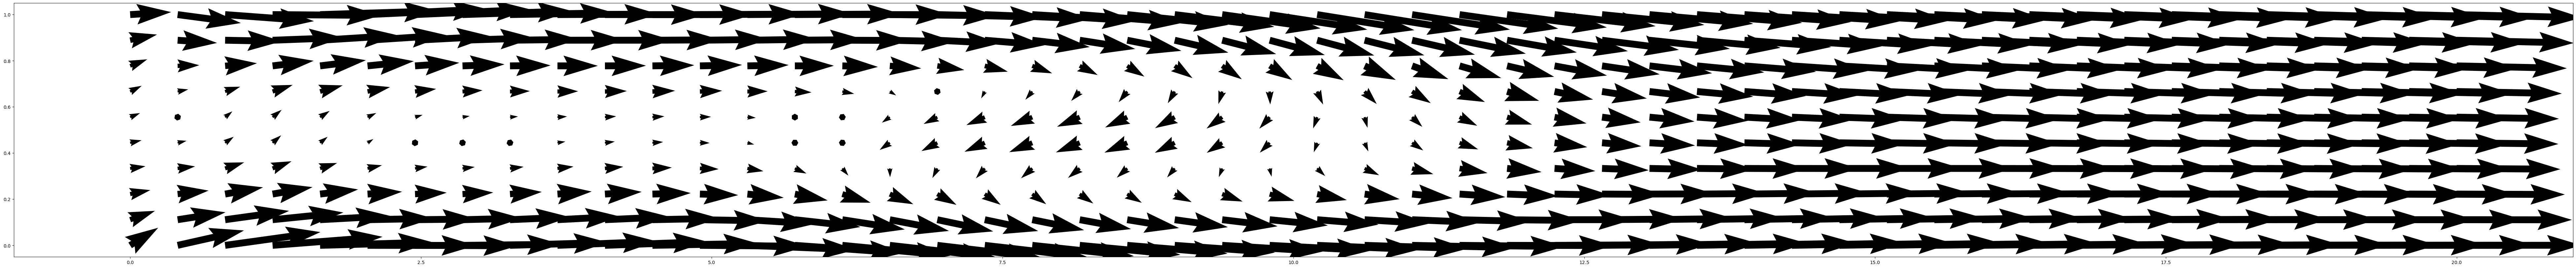

Text(0, 0.5, 'u')

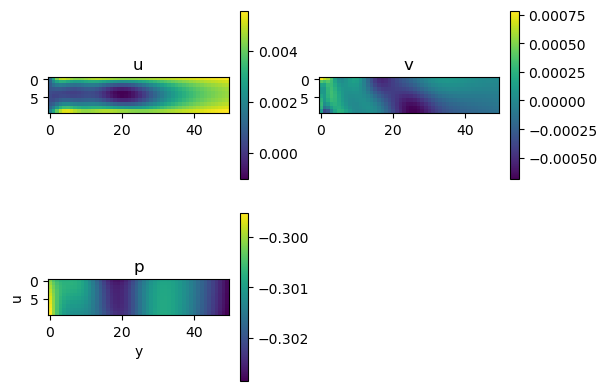

In [28]:

t_bc=np.zeros(1)
x_bc=np.linspace(0,20,50)
y_bc=np.linspace(0,1,10)
t_bcm,x_bcm, y_bcm=np.meshgrid(t_bc,x_bc,y_bc)
t_bcm=np.reshape(t_bcm,(500,1))
x_bcm=np.reshape(x_bcm,(500,1))
y_bcm=np.reshape(y_bcm,(500,1))
pt_t_bc= Variable(torch.from_numpy(t_bcm).float(), requires_grad=True).to(device)
pt_x_bc= Variable(torch.from_numpy(x_bcm).float(), requires_grad=True).to(device)
pt_y_bc= Variable(torch.from_numpy(y_bcm).float(), requires_grad=True).to(device)
psi=model(pt_t_bc,pt_x_bc,pt_y_bc)[:,0]
print(np.shape(psi))
p=model(pt_t_bc,pt_x_bc,pt_y_bc)[:,1]
u = torch.autograd.grad(psi.sum(), pt_y_bc, create_graph=True)[0]
v = -torch.autograd.grad(psi.sum(), pt_x_bc, create_graph=True)[0]
fig=plt.gcf()
fig.set_size_inches(100,10)
plt.quiver(x_bcm,y_bcm,u.detach().numpy().reshape((50,10)),v.detach().numpy().reshape((50,10)))
plt.show()
plt.subplot(2,2,1)
plt.imshow(u.detach().numpy().reshape((50,10)).T)
plt.title('u')
plt.colorbar()
plt.subplot(2,2,2)
plt.imshow(v.detach().numpy().reshape((50,10)).T)
plt.title('v')
plt.colorbar()
plt.subplot(2,2,3)
plt.imshow(p.detach().numpy().reshape((50,10)).T)
plt.title('p')
plt.colorbar()

#plt.plot(np.linspace(0,1,50),(np.linspace(0,1,50)-0.5)**2*0.5-0.125)
plt.xlabel('y')
plt.ylabel('u')
#plt.plot(t_test, np.sin(t_test))